In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/msk-redefining-cancer-treatment/training_text.zip
/kaggle/input/msk-redefining-cancer-treatment/stage2_test_variants.csv.7z
/kaggle/input/msk-redefining-cancer-treatment/stage1_solution_filtered.csv.7z
/kaggle/input/msk-redefining-cancer-treatment/stage2_test_text.csv.7z
/kaggle/input/msk-redefining-cancer-treatment/test_text.zip
/kaggle/input/msk-redefining-cancer-treatment/test_variants.zip
/kaggle/input/msk-redefining-cancer-treatment/stage2_sample_submission.csv.7z
/kaggle/input/msk-redefining-cancer-treatment/stage_2_private_solution.csv.7z
/kaggle/input/msk-redefining-cancer-treatment/training_variants.zip


# Personalized Cancer Diagnosis

<h1> 1. Business Problem </h1>
<h3> 1.1 Description </h3>


Once sequenced, a cancer tumor can have thousands of genetic mutations. But the challenge is distinguishing the mutations that contribute to tumor growth (drivers) from the neutral mutations (passengers). 

Currently this interpretation of genetic mutations is being done manually. This is a very time-consuming task where a clinical pathologist has to manually review and classify every single genetic mutation based on evidence from text-based clinical literature.

For this competition MSKCC is making available an expert-annotated knowledge base where world-class researchers and oncologists have manually annotated thousands of mutations.

We've to develop a Machine Learning algorithm that, using this knowledge base as a baseline, automatically classifies genetic variations.

**Source** https://www.kaggle.com/c/msk-redefining-cancer-treatment/overview

<h3> Business Objectives </h3>



* No low-latency requirement
* Interpretability is very important.
* Errors can be very costly.
* We need probability of a data point belonging to each class rather class value.

<h1>2. Machine Learning Problem Formulation </h1>

<h3> 2.1. Data </h3>

<h4> 2.1.1 Data Overview </h4>

*  We have two data files: one conatins the information about the genetic mutations and the other contains the clinical evidence (text) that  human experts/pathologists use to classify the genetic mutations. 
*  Both these data files are have a common column called ID
- <p> 
    Data file's information:
    <ul> 
        <li>
        training_variants (ID , Gene, Variations, Class)
        </li>
        <li>
        training_text (ID, Text)
        </li>
    </ul>
</p>

<h3> 2.2 Mapping the real world problem to an ML Problem </h3>

<h4> 2.2.1 Type of Machine Learning Problem </h4>

    
 * Multiclass Classification Problem

<h4> 2.2.2 Performance Metric </h4> 

* Multi-class log-loss
* Confusion Matrix

<h4> 2.2.3 Machine Learning Objectives & Constraints
    

**Objective**
* Predict the probability of each data-point belonging to each of the nine classes.

**Constraints**
* Interpretability
* Class probabilities are needed.
* Penalize the errors in class probabilites => Metric is Log-loss.
* No Latency constraints.

<h4>2.2.4 Train, CV and Test Datasets </h4>
 Split the dataset randomly into three parts train, cross validation and test with 64%,16%, 20% of data respectively

<h1>3. Exploratory Data Analysis </h1>

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import numpy as np
from nltk.corpus import stopwords
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from imblearn.over_sampling import SMOTE
from collections import Counter
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold 
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier
warnings.filterwarnings("ignore")

from mlxtend.classifier import StackingClassifier

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression

import warnings
warnings.filterwarnings("ignore")

/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


<h3>3.1 Reading Data </h3>

<h4> 3.1.1 Reading gene and variation data </h4>

In [3]:
data = pd.read_csv('../input/msk-redefining-cancer-treatment/training_variants.zip')
print('Number of data points : ', data.shape[0])
print('Number of features : ', data.shape[1])
print('Features : ', data.columns.values)
data.head()

Number of data points :  3321
Number of features :  4
Features :  ['ID' 'Gene' 'Variation' 'Class']


,ID,Gene,Variation,Class
0,0,FAM58A,Truncating Mutations,1
1,1,CBL,W802*,2
2,2,CBL,Q249E,2
3,3,CBL,N454D,3
4,4,CBL,L399V,4


Fields are 
    <ul>
        <li><b>ID : </b>the id of the row used to link the mutation to the clinical evidence</li>
        <li><b>Gene : </b>the gene where this genetic mutation is located </li>
        <li><b>Variation : </b>the aminoacid change for this mutations </li>
        <li><b>Class :</b> 1-9 the class this genetic mutation has been classified on</li>
    </ul>

<h4> 3.1.2 Reading text data </h4>

In [4]:
# note the seprator in this file
data_text =pd.read_csv("../input/msk-redefining-cancer-treatment/training_text.zip",sep="\|\|",engine="python",names=["ID","TEXT"],skiprows=1)
print('Number of data points : ', data_text.shape[0])
print('Number of features : ', data_text.shape[1])
print('Features : ', data_text.columns.values)
data_text.head()

Number of data points :  3321
Number of features :  2
Features :  ['ID' 'TEXT']


,ID,TEXT
0,0,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,Abstract Background Non-small cell lung canc...
2,2,Abstract Background Non-small cell lung canc...
3,3,Recent evidence has demonstrated that acquired...
4,4,Oncogenic mutations in the monomeric Casitas B...


In [5]:
data_text.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3321 entries, 0 to 3320
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ID      3321 non-null   int64 
 1   TEXT    3316 non-null   object
dtypes: int64(1), object(1)
memory usage: 52.0+ KB


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3321 entries, 0 to 3320
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ID         3321 non-null   int64 
 1   Gene       3321 non-null   object
 2   Variation  3321 non-null   object
 3   Class      3321 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 103.9+ KB


<h4> 3.1.3 Preprocessing of text </h4>

In [7]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [8]:
# loading stop words from nltk library
stop_words = set(stopwords.words('english'))


def nlp_preprocessing(total_text, index, column):
    if type(total_text) is not int:
        string = ""
        # replace every special char with space
        total_text = re.sub('[^a-zA-Z0-9\n]', ' ', total_text)
        # replace multiple spaces with single space
        total_text = re.sub('\s+',' ', total_text)
        # converting all the chars into lower-case.
        total_text = total_text.lower()
        
        for word in total_text.split():
        # if the word is a not a stop word then retain that word from the data
            if not word in stop_words:
                string += word + " "
        
        data_text[column][index] = string

In [9]:
#text processing stage.
start_time = time.clock()
for index,row in data_text.iterrows():
    if type(row['TEXT']) is str:
        nlp_preprocessing(row['TEXT'], index, 'TEXT')
    else:
        print("there is no text description for id:",index)
print('Time took for preprocessing the text :',time.clock() - start_time, "seconds")

there is no text description for id: 1109
there is no text description for id: 1277
there is no text description for id: 1407
there is no text description for id: 1639
there is no text description for id: 2755
Time took for preprocessing the text : 39.650049 seconds


In [10]:
df = pd.merge(data,data_text,on = 'ID', how = 'left')
df.head()

,ID,Gene,Variation,Class,TEXT
0,0,FAM58A,Truncating Mutations,1,cyclin dependent kinases cdks regulate variety...
1,1,CBL,W802*,2,abstract background non small cell lung cancer...
2,2,CBL,Q249E,2,abstract background non small cell lung cancer...
3,3,CBL,N454D,3,recent evidence demonstrated acquired uniparen...
4,4,CBL,L399V,4,oncogenic mutations monomeric casitas b lineag...


In [11]:
df.loc[(df.TEXT.isnull()),'TEXT'] = df['Gene'] + df['Variation']

In [12]:
df[df['ID'] == 1109]

,ID,Gene,Variation,Class,TEXT
1109,1109,FANCA,S1088F,1,FANCAS1088F


In [13]:
y = df['Class']

In [14]:
df.Gene = df.Gene.str.replace('\s+', '_')
df.Variation = df.Variation.str.replace('\s+', '_')

<h4> 3.1.4 Train, Test and Cross Validation Split </h4>

Splitting data into train, test and cross validation 

In [15]:
# split the data into test and train by maintaining same distribution of output varaible 'y_true' [stratify=y_true]
x_train, x_test, y_train, y_test = train_test_split(df, y, stratify=y, test_size=0.2)

In [16]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(2656, 5)
(665, 5)
(2656,)
(665,)


In [17]:
# split the train data into train and cross validation by maintaining same distribution of output varaible 'y_train' [stratify=y_train]
x_train, x_cv, y_train, y_cv = train_test_split(x_train, y_train, stratify=y_train, test_size=0.2)

We split the data into train, test and cross validation data sets, preserving the ratio of class distribution in the original data set

In [18]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)
print(x_cv.shape)
print(y_cv.shape)

(2124, 5)
(2124,)
(665, 5)
(665,)
(532, 5)
(532,)


In [19]:
train_class = (x_train.Class.value_counts().sort_index())
test_class = (x_test.Class.value_counts().sort_index())
cv_class = (x_cv.Class.value_counts().sort_index())

<h4> 3.1.4.1 Distribution of y_i's in Train, Test and Cross Validation datasets</h4>

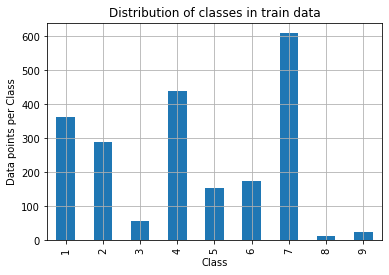

****************************************************************************************************


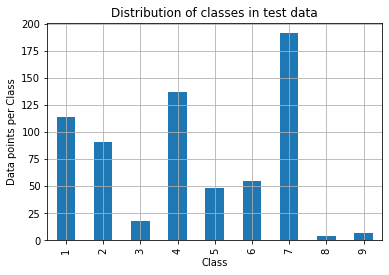

****************************************************************************************************


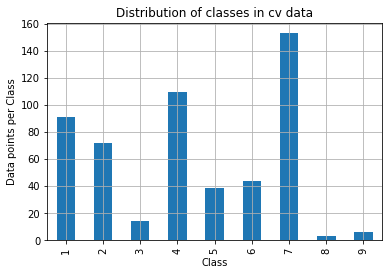

****************************************************************************************************


In [20]:
my_colors = 'rgbkymc'
train_class.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of classes in train data')
plt.grid()
plt.show()

print('*'* 100)

my_colors = 'rgbkymc'
test_class.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of classes in test data')
plt.grid()
plt.show()

print('*'* 100)

my_colors = 'rgbkymc'
cv_class.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of classes in cv data')
plt.grid()
plt.show()

print('*'* 100)

In [21]:
#This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    
    labels = [1,2,3,4,5,6,7,8,9]
    # representing A in heatmap format
    print("-"*20, "Confusion matrix", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(C, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

    print("-"*20, "Precision matrix (Columm Sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(B, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    
    # representing B in heatmap format
    print("-"*20, "Recall matrix (Row sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(A, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

<h3> 3.2 Univariate Analysis </h3>

In [22]:
# code for response coding with Laplace smoothing.
# alpha : used for laplace smoothing
# feature: ['gene', 'variation']
# df: ['train_df', 'test_df', 'cv_df']
# algorithm
# ----------
# Consider all unique values and the number of occurances of given feature in train data dataframe
# build a vector (1*9) , the first element = (number of times it occured in class1 + 10*alpha / number of time it occurred in total data+90*alpha)
# gv_dict is like a look up table, for every gene it store a (1*9) representation of it
# for a value of feature in df:
# if it is in train data:
# we add the vector that was stored in 'gv_dict' look up table to 'gv_fea'
# if it is not there is train:
# we add [1/9, 1/9, 1/9, 1/9,1/9, 1/9, 1/9, 1/9, 1/9] to 'gv_fea'
# return 'gv_fea'
# ----------------------

# get_gv_fea_dict: Get Gene varaition Feature Dict
def get_gv_fea_dict(alpha, feature, df):
    # value_count: it contains a dict like
    # print(train_df['Gene'].value_counts())
    # output:
    #        {BRCA1      174
    #         TP53       106
    #         EGFR        86
    #         BRCA2       75
    #         PTEN        69
    #         KIT         61
    #         BRAF        60
    #         ERBB2       47
    #         PDGFRA      46
    #         ...}
    # print(train_df['Variation'].value_counts())
    # output:
    # {
    # Truncating_Mutations                     63
    # Deletion                                 43
    # Amplification                            43
    # Fusions                                  22
    # Overexpression                            3
    # E17K                                      3
    # Q61L                                      3
    # S222D                                     2
    # P130S                                     2
    # ...
    # }
    value_count = x_train[feature].value_counts()
    
    # gv_dict : Gene Variation Dict, which contains the probability array for each gene/variation
    gv_dict = dict()
    
    # denominator will contain the number of time that particular feature occured in whole data
    for i, denominator in value_count.items():
        # i - Gene/variant name and denominator = num of time feature occured.
        # vec will contain (p(yi==1/Gi) probability of gene/variation belongs to perticular class
        # vec is 9 dimensional vector
        vec = []
        for k in range(1,10):
            # print(train_df.loc[(train_df['Class']==1) & (train_df['Gene']=='BRCA1')])
            #         ID   Gene             Variation  Class  
            # 2470  2470  BRCA1                S1715C      1   
            # 2486  2486  BRCA1                S1841R      1   
            # 2614  2614  BRCA1                   M1R      1   
            # 2432  2432  BRCA1                L1657P      1   
            # 2567  2567  BRCA1                T1685A      1   
            # 2583  2583  BRCA1                E1660G      1   
            # 2634  2634  BRCA1                W1718L      1   
            # cls_cnt.shape[0] will return the number of rows

            #cls_cnt contins the dataframe with class = k and feature = i
            cls_cnt = x_train.loc[(x_train['Class']==k) & (x_train[feature]==i)]
            
            # cls_cnt.shape[0](numerator) will contain the number of time that particular feature occured in whole data
            vec.append((cls_cnt.shape[0] + alpha*10)/ (denominator + 90*alpha))

        # we are adding the gene/variation to the dict as key and vec as value
        gv_dict[i]=vec
    return gv_dict

# Get Gene variation feature
def get_gv_feature(alpha, feature, df):
    # print(gv_dict)
    #     {'BRCA1': [0.20075757575757575, 0.03787878787878788, 0.068181818181818177, 0.13636363636363635, 0.25, 0.19318181818181818, 0.03787878787878788, 0.03787878787878788, 0.03787878787878788], 
    #      'TP53': [0.32142857142857145, 0.061224489795918366, 0.061224489795918366, 0.27040816326530615, 0.061224489795918366, 0.066326530612244902, 0.051020408163265307, 0.051020408163265307, 0.056122448979591837], 
    #      'EGFR': [0.056818181818181816, 0.21590909090909091, 0.0625, 0.068181818181818177, 0.068181818181818177, 0.0625, 0.34659090909090912, 0.0625, 0.056818181818181816], 
    #      'BRCA2': [0.13333333333333333, 0.060606060606060608, 0.060606060606060608, 0.078787878787878782, 0.1393939393939394, 0.34545454545454546, 0.060606060606060608, 0.060606060606060608, 0.060606060606060608], 
    #      'PTEN': [0.069182389937106917, 0.062893081761006289, 0.069182389937106917, 0.46540880503144655, 0.075471698113207544, 0.062893081761006289, 0.069182389937106917, 0.062893081761006289, 0.062893081761006289], 
    #      'KIT': [0.066225165562913912, 0.25165562913907286, 0.072847682119205295, 0.072847682119205295, 0.066225165562913912, 0.066225165562913912, 0.27152317880794702, 0.066225165562913912, 0.066225165562913912], 
    #      'BRAF': [0.066666666666666666, 0.17999999999999999, 0.073333333333333334, 0.073333333333333334, 0.093333333333333338, 0.080000000000000002, 0.29999999999999999, 0.066666666666666666, 0.066666666666666666],
    #      ...
    #     }
    gv_dict = get_gv_fea_dict(alpha, feature, df)
    # value_count is similar in get_gv_fea_dict
    value_count = x_train[feature].value_counts()
    
    # gv_fea: Gene_variation feature, it will contain the feature for each feature value in the data
    gv_fea = []
    # for every feature values in the given data frame we will check if it is there in the train data then we will add the feature to gv_fea
    # if not we will add [1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9] to gv_fea
    for index, row in df.iterrows():
        if row[feature] in dict(value_count).keys():
            gv_fea.append(gv_dict[row[feature]])
        else:
            gv_fea.append([1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9])
#             gv_fea.append([-1,-1,-1,-1,-1,-1,-1,-1,-1])
    return gv_fea

<h4> 3.2.1 Univariate Analysis on Gene feature </h4>

* Gene is categorical variable.

In [23]:
unique_genes = x_train['Gene'].value_counts()
print("Total number of unique genes are:", unique_genes.shape[0])
print(unique_genes.head())

Total number of unique genes are: 234
BRCA1    169
TP53     111
EGFR      96
PTEN      79
BRCA2     72
Name: Gene, dtype: int64


* 234 unique categories

In [24]:
type(unique_genes)

pandas.core.series.Series

**Distribution of genes**

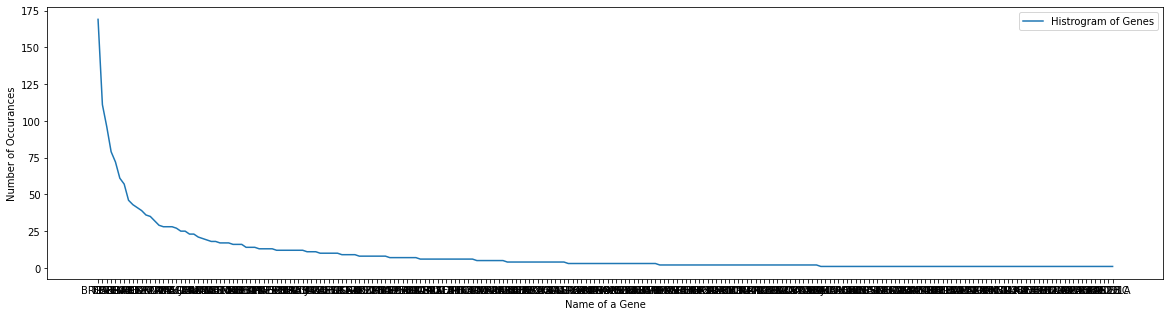

In [25]:
plt.figure(figsize=(20, 5))
plt.plot(unique_genes, label="Histrogram of Genes")
plt.xlabel('Name of a Gene')
plt.ylabel('Number of Occurances')
plt.legend()
#plt.grid()
plt.show()

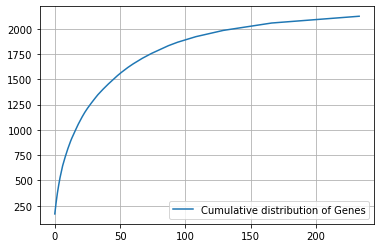

In [26]:
c = np.cumsum(unique_genes.values)
plt.plot(c,label='Cumulative distribution of Genes')
plt.grid()
plt.legend()
plt.show()

* #### Featurization of Gene feature
   1. There are two ways we can featurize this variable
        * One hot Encoding
        * Response coding
* We will choose the appropriate featurization based on the ML model we use. 
* For this problem of multi-class classification with categorical features, one-hot encoding is better for Logistic regression while response coding is better for Random Forests.

In [27]:
#response-coding of the Gene feature
# alpha is used for laplace smoothing
alpha = 1
# train gene feature
train_gene_response = np.array(get_gv_feature(alpha, "Gene", x_train))
# test gene feature
test_gene_response = np.array(get_gv_feature(alpha, "Gene", x_test))
# cross validation gene feature
cv_gene_response = np.array(get_gv_feature(alpha, "Gene", x_cv))

In [28]:
print("train_gene_response is converted feature using respone coding method. The shape of gene feature:", train_gene_response.shape)

train_gene_response is converted feature using respone coding method. The shape of gene feature: (2124, 9)


In [29]:
# one-hot encoding of Gene feature.
gene_vectorizer = CountVectorizer()
train_gene_onehotCoding = gene_vectorizer.fit_transform(x_train['Gene'])
test_gene_onehotCoding = gene_vectorizer.transform(x_test['Gene'])
cv_gene_onehotCoding = gene_vectorizer.transform(x_cv['Gene'])

In [30]:
gene_vectorizer.get_feature_names()

['abl1',
 'acvr1',
 'ago2',
 'akt1',
 'akt2',
 'akt3',
 'alk',
 'apc',
 'ar',
 'araf',
 'arid1a',
 'arid1b',
 'arid2',
 'arid5b',
 'atm',
 'atrx',
 'axin1',
 'axl',
 'b2m',
 'bap1',
 'bard1',
 'bcl10',
 'bcl2',
 'bcl2l11',
 'bcor',
 'braf',
 'brca1',
 'brca2',
 'brd4',
 'brip1',
 'btk',
 'card11',
 'carm1',
 'casp8',
 'cbl',
 'ccnd1',
 'ccnd2',
 'ccnd3',
 'ccne1',
 'cdh1',
 'cdk12',
 'cdk4',
 'cdkn1a',
 'cdkn1b',
 'cdkn2a',
 'cdkn2b',
 'cdkn2c',
 'cebpa',
 'chek2',
 'cic',
 'crebbp',
 'ctcf',
 'ctla4',
 'ctnnb1',
 'ddr2',
 'dicer1',
 'dnmt3a',
 'dnmt3b',
 'dusp4',
 'egfr',
 'elf3',
 'ep300',
 'epas1',
 'epcam',
 'erbb2',
 'erbb3',
 'erbb4',
 'ercc2',
 'ercc3',
 'ercc4',
 'erg',
 'esr1',
 'etv1',
 'etv6',
 'ewsr1',
 'ezh2',
 'fanca',
 'fancc',
 'fat1',
 'fbxw7',
 'fgf3',
 'fgfr1',
 'fgfr2',
 'fgfr3',
 'flt3',
 'foxa1',
 'foxl2',
 'foxo1',
 'foxp1',
 'fubp1',
 'gata3',
 'gli1',
 'gna11',
 'gnas',
 'h3f3a',
 'hist1h1c',
 'hla',
 'hnf1a',
 'hras',
 'idh1',
 'idh2',
 'igf1r',
 'ikbke',
 'in

In [31]:
print("train_gene_onehotCoding is converted feature using one-hot encoding method. The shape of gene feature:", train_gene_onehotCoding.shape)

train_gene_onehotCoding is converted feature using one-hot encoding method. The shape of gene feature: (2124, 233)


* **Effectiveness of gene feature in prediction**
    * There are many ways to estimate how good a feature is, in predicting y_i. One of the good methods is to build a proper ML model using just this feature. In this case, we will build a logistic regression model using only Gene feature (one hot encoded) for prediction of target variable.

In [32]:
from sklearn.calibration import CalibratedClassifierCV

For alpha = 1e-05 the log-loss is 1.1882808003502174
For alpha = 0.0001 the log-loss is 1.178231222276338
For alpha = 0.001 the log-loss is 1.2376732185106338
For alpha = 0.01 the log-loss is 1.3595635278126719
For alpha = 0.1 the log-loss is 1.4375641144737008
For alpha = 1 the log-loss is 1.4708192293426856


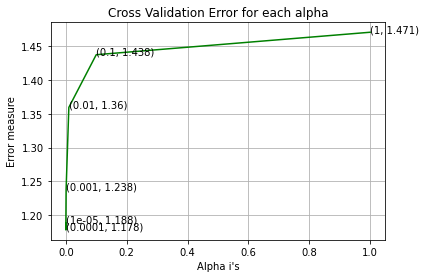

For values of best alpha =  0.0001 The train log loss is: 0.9921017186411993
For values of best alpha =  0.0001 The cross validation log loss is: 1.178231222276338
For values of best alpha =  0.0001 The test log loss is: 1.1596639949995693


In [33]:
alpha = [10 ** x for x in range(-5,1)]

cv_log_error_array = []
for i in alpha:
    clf = SGDClassifier(loss = 'log', penalty = 'l2', alpha = i, random_state = 42)
    clf.fit(train_gene_onehotCoding,y_train)
    sig_clf = CalibratedClassifierCV(clf, method = 'sigmoid')
    sig_clf.fit(train_gene_onehotCoding,y_train)
    predict_y = sig_clf.predict_proba(cv_gene_onehotCoding)
    cv_log_error_array.append(log_loss(y_cv,predict_y,labels = clf.classes_))
    print("For alpha =",i,"the log-loss is",log_loss(y_cv,predict_y,labels = clf.classes_))

fig,ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show() 

best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(loss = 'log', penalty = 'l2', alpha = alpha[best_alpha], random_state = 42)
clf.fit(train_gene_onehotCoding,y_train)
sig_clf = CalibratedClassifierCV(clf, method = 'sigmoid')
sig_clf.fit(train_gene_onehotCoding,y_train)
    
    
predict_y = sig_clf.predict_proba(train_gene_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train,predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_gene_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv,predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_gene_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test,predict_y, labels=clf.classes_,eps=1e-15))

**Is the Gene feature stable across all the data sets (Test, Train, Cross validation)?**
   * Yes, it is. Otherwise, the CV and Test errors would be significantly more than train error. </p>

In [34]:
print("Number of data points in Test and CV datasets covered by", unique_genes.shape[0],"genes in train dataset")

test_coverage = x_test[x_test['Gene'].isin(list(set(x_train['Gene'])))].shape[0]
cv_coverage = x_cv[x_cv['Gene'].isin(list(set(x_train['Gene'])))].shape[0]

print('Ans\n1. In test data',test_coverage, 'out of',x_test.shape[0], ":",(test_coverage/x_test.shape[0])*100)
print('2. In cross validation data',cv_coverage, 'out of ',x_cv.shape[0],":" ,(cv_coverage/x_cv.shape[0])*100)

Number of data points in Test and CV datasets covered by 234 genes in train dataset
Ans
1. In test data 647 out of 665 : 97.29323308270676
2. In cross validation data 511 out of  532 : 96.05263157894737


<h4>3.2.2 Univariate Analysis on Variation feature </h4>

*  Variation is a categorical variable

In [35]:
unique_variations = x_train['Variation'].value_counts()
print("Total number of unique Variations are:", unique_variations.shape[0])
print(unique_variations.head())

Total number of unique Variations are: 1936
Truncating_Mutations    56
Deletion                48
Amplification           41
Fusions                 21
Overexpression           4
Name: Variation, dtype: int64


* Total number of unique variations = 1936

**Distribution of Variation**

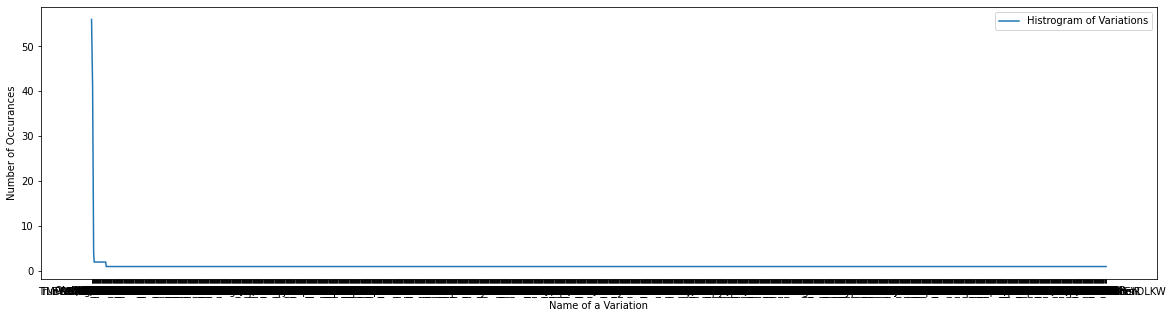

In [36]:
plt.figure(figsize=(20, 5))
plt.plot(unique_variations, label="Histrogram of Variations")
plt.xlabel('Name of a Variation')
plt.ylabel('Number of Occurances')
plt.legend()
#plt.grid()
plt.show()

Truncating_Mutations      56
Deletion                 104
Amplification            145
Fusions                  166
Overexpression           170
                        ... 
T1691I                  2120
E82V                    2121
G13D                    2122
R156H                   2123
R1276P                  2124
Name: Variation, Length: 1936, dtype: int64


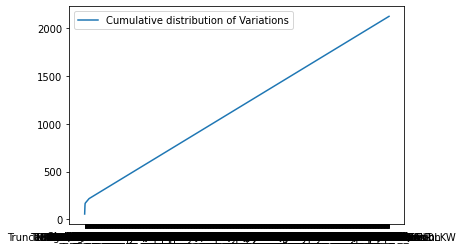

In [37]:
c = np.cumsum(unique_variations)
print(c)
plt.plot(c,label='Cumulative distribution of Variations')
#plt.grid()
plt.legend()
plt.show()

* **Featurization of Variation feature**
   1. There are two ways we can featurize this variable
        * One hot Encoding
        * Response coding
* We will choose the appropriate featurization based on the ML model we use. 
* For this problem of multi-class classification with categorical features, one-hot encoding is better for Logistic regression while response coding is better for Random Forests.

In [38]:
#response-coding of the Variation feature
# alpha is used for laplace smoothing
alpha = 1
# train variation feature
train_variation_response = np.array(get_gv_feature(alpha, "Variation", x_train))
# test variation feature
test_variation_response = np.array(get_gv_feature(alpha, "Variation", x_test))
# cross validation variation  feature
cv_variation_response = np.array(get_gv_feature(alpha, "Variation", x_cv))

In [39]:
print("train_variation_response is converted feature using respone coding method. The shape of variation feature:", train_variation_response.shape)

train_variation_response is converted feature using respone coding method. The shape of variation feature: (2124, 9)


In [40]:
# one-hot encoding of Gene feature.
var_vectorizer = CountVectorizer()
train_variation_onehotCoding = var_vectorizer.fit_transform(x_train['Variation'])
test_variation_onehotCoding = var_vectorizer.transform(x_test['Variation'])
cv_variation_onehotCoding = var_vectorizer.transform(x_cv['Variation'])

In [41]:
print("train_variation_onehotCoding is converted feature using one-hot encoding method. The shape of variation feature:", train_variation_onehotCoding.shape)

train_variation_onehotCoding is converted feature using one-hot encoding method. The shape of variation feature: (2124, 1965)


* **Effectiveness of variation feature in prediction**
    * There are many ways to estimate how good a feature is, in predicting target. One of the good methods is to build a proper ML model using just this feature. In this case, we will build a logistic regression model using only Variation feature (one hot encoded) for prediction of target variable.

For alpha = 1e-05 the log-loss is 1.7286091765215152
For alpha = 0.0001 the log-loss is 1.716652683203574
For alpha = 0.001 the log-loss is 1.7210558252805288
For alpha = 0.01 the log-loss is 1.7251960057386866
For alpha = 0.1 the log-loss is 1.7268515551886576
For alpha = 1 the log-loss is 1.728186902270783


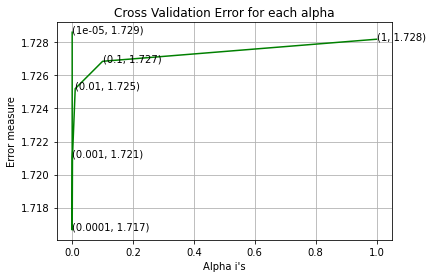

For values of best alpha =  0.0001 The train log loss is: 0.674657420331945
For values of best alpha =  0.0001 The cross validation log loss is: 1.716652683203574
For values of best alpha =  0.0001 The test log loss is: 1.6771835257531513


In [42]:
alpha = [10 ** x for x in range(-5,1)]

cv_log_error_array = []
for i in alpha:
    clf = SGDClassifier(loss = 'log', penalty = 'l2', alpha = i, random_state = 42)
    clf.fit(train_variation_onehotCoding,y_train)
    sig_clf = CalibratedClassifierCV(clf, method = 'sigmoid')
    sig_clf.fit(train_variation_onehotCoding,y_train)
    predict_y = sig_clf.predict_proba(cv_variation_onehotCoding)
    cv_log_error_array.append(log_loss(y_cv,predict_y,labels = clf.classes_))
    print("For alpha =",i,"the log-loss is",log_loss(y_cv,predict_y,labels = clf.classes_))

fig,ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show() 

best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(loss = 'log', penalty = 'l2', alpha = alpha[best_alpha], random_state = 42)
clf.fit(train_variation_onehotCoding,y_train)
sig_clf = CalibratedClassifierCV(clf, method = 'sigmoid')
sig_clf.fit(train_variation_onehotCoding,y_train)
    
    
predict_y = sig_clf.predict_proba(train_variation_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train,predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_variation_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv,predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_variation_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test,predict_y, labels=clf.classes_,eps=1e-15))

**Stability of Variation feature across all the datasets**
* Not sure! But lets be very sure using the below analysis.

In [43]:
print("Number of data points in Test and CV datasets covered by", unique_variations.shape[0],"genes in train dataset")

test_coverage = x_test[x_test['Variation'].isin(list(set(x_train['Variation'])))].shape[0]
cv_coverage = x_cv[x_cv['Variation'].isin(list(set(x_train['Variation'])))].shape[0]

print('Ans\n1. In test data',test_coverage, 'out of',x_test.shape[0], ":",(test_coverage/x_test.shape[0])*100)
print('2. In cross validation data',cv_coverage, 'out of ',x_cv.shape[0],":" ,(cv_coverage/x_cv.shape[0])*100)

Number of data points in Test and CV datasets covered by 1936 genes in train dataset
Ans
1. In test data 79 out of 665 : 11.879699248120302
2. In cross validation data 52 out of  532 : 9.774436090225564


<h3>3.2.3 Univariate Analysis on Text Feature</h3>

In [44]:
x_test.head()

,ID,Gene,Variation,Class,TEXT
1179,1179,PIK3CA,N1044K,7,large scale sequencing efforts uncovering comp...
157,157,EGFR,T710A,2,many complex rare mutations epidermal growth f...
2166,2166,PTEN,Y174N,4,tumor suppressor gene pten frequently mutated ...
908,908,PDGFRA,D842V,7,purpose platelet derived growth factor recepto...
2906,2906,NF2,Q538P,1,neurofibromatosis 2 nf2 tumor predisposition s...


In [45]:
# cls_text is a data frame
# for every row in data frame consider the 'TEXT'
# split the words by space
# make a dict with those words
# increment its count whenever we see that word

#In a nutshell, this function returns a dictionary with key : word and value : count of word in that dataframe.
def extract_dictionary_paddle(cls_text):
    dictionary = defaultdict(int)
    for index, row in cls_text.iterrows():
        for word in row['TEXT'].split():
            dictionary[word] +=1
    return dictionary

In [46]:
#dictionary of dictionaries
dict_list = []       
# dict_list =[] contains 9 dictionaries each corresponds to a class
for i in range(1,10):
    cls_text = x_train[x_train['Class']==i]
    # build a word dict based on the words in that class
    dict_list.append(extract_dictionary_paddle(cls_text))
    # append it to dict_list


In [47]:
#we calculate total number of words present in each class
total_words_inclass_dict = defaultdict(int)
for i in range(1,10):
    txt = x_train[x_train['Class'] == i]
    for index,row in txt.iterrows():
        for word in row['TEXT'].split():
            total_words_inclass_dict[i] += 1

In [48]:
total_words_inclass_dict

defaultdict(int,
            {1: 2423471,
             2: 1897390,
             3: 244974,
             4: 2879752,
             5: 838247,
             6: 960596,
             7: 5002383,
             8: 103808,
             9: 236724})

**Response Encoding of text feature**

In [49]:
import math
#https://stackoverflow.com/a/1602964
def get_text_responsecoding(df):
    text_feature_responseCoding = np.zeros((df.shape[0],9))
    for i in range(0,9):
        row_index = 0
        for index, row in df.iterrows():
            sum_prob = 0
            for word in row['TEXT'].split():
                sum_prob += math.log(((dict_list[i].get(word,0)+10 )/(total_words_inclass_dict[i+1]+90)))
            text_feature_responseCoding[row_index][i] = math.exp(sum_prob/len(row['TEXT'].split()))
            row_index += 1
    return text_feature_responseCoding

In [50]:
#response coding of text features
train_text_response = get_text_responsecoding(x_train)
test_text_response = get_text_responsecoding(x_test)
cv_text_response = get_text_responsecoding(x_cv)

**One hot encoding of text feature**

In [51]:
# building a CountVectorizer with all the words that occured minimum 3 times in train data
text_vectorizer = CountVectorizer(min_df=3)
train_text_bow = text_vectorizer.fit_transform(x_train['TEXT'])


In [52]:
# getting all the feature names (words)
train_text_features= text_vectorizer.get_feature_names()

# train_text_bow.sum(axis=0).A1 will sum every row and returns (1*number of features) vector
# .A1 returns a flattened ndarray
train_text_feature_counts = train_text_bow.sum(axis=0).A1

print(train_text_feature_counts)
# zip(list(text_features),text_fea_counts) will zip a word with its number of times it occured
text_fea_dict = dict(zip(list(train_text_features),train_text_feature_counts))


print("Total number of unique words in train data :", len(train_text_features))

[2387 5470    9 ...   10    5   16]
Total number of unique words in train data : 53183


In [53]:
# we use the same vectorizer that was trained on train data
test_text_bow = text_vectorizer.transform(x_test['TEXT'])

# we use the same vectorizer that was trained on train data
cv_text_bow = text_vectorizer.transform(x_cv['TEXT'])

**Check how effective text feature is**
* by using one hot encoded text feature

For values of alpha =  1e-05 The log loss is: 1.8308896108218553
For values of alpha =  0.0001 The log loss is: 1.8308896108218553
For values of alpha =  0.001 The log loss is: 1.2602342318398134
For values of alpha =  0.01 The log loss is: 1.2865230566265693
For values of alpha =  0.1 The log loss is: 1.2561058748233478
For values of alpha =  1 The log loss is: 1.1820299875466023


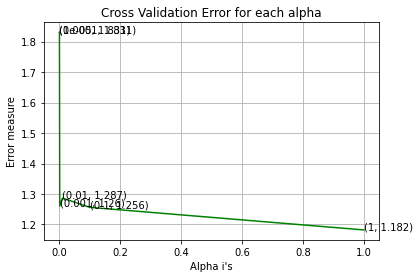

For values of best alpha =  1 The train log loss is: 0.8348904435546429
For values of best alpha =  1 The cross validation log loss is: 1.1820299875466023
For values of best alpha =  1 The test log loss is: 1.181520988838771


In [54]:
# Train a Logistic regression+Calibration model using text features whicha re on-hot encoded
alpha = [10 ** x for x in range(-5, 1)]

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.


cv_log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_text_bow, y_train)
    
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_text_bow, y_train)
    predict_y = sig_clf.predict_proba(cv_text_bow)
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_text_bow, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_text_bow, y_train)

predict_y = sig_clf.predict_proba(train_text_bow)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_text_bow)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_text_bow)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


In [55]:
def get_intersec_text(df):
    df_text_vec = CountVectorizer(min_df=3)
    df_text_fea = df_text_vec.fit_transform(df['TEXT'])
    df_text_features = df_text_vec.get_feature_names()

    df_text_fea_counts = df_text_fea.sum(axis=0).A1
    df_text_fea_dict = dict(zip(list(df_text_features),df_text_fea_counts))
    len1 = len(set(df_text_features))
    len2 = len(set(train_text_features) & set(df_text_features))
    return len1,len2

**Check if text feature is stable across each data**

In [56]:
len1,len2 = get_intersec_text(x_test)
print(np.round((len2/len1)*100, 3), "% of word of test data appeared in train data")
len1,len2 = get_intersec_text(x_cv)
print(np.round((len2/len1)*100, 3), "% of word of Cross Validation appeared in train data")

97.781 % of word of test data appeared in train data
97.029 % of word of Cross Validation appeared in train data


<h1> 4. Machine Learning Models </h1>

* Function to plot confusion matrix

In [57]:
#Data preparation for ML models.
#Misc. functions for ML models

def predict_and_plot_confusion_matrix(train_x, train_y,test_x, test_y, clf):
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
    pred_y = sig_clf.predict(test_x)

    # for calculating log_loss we willl provide the array of probabilities belongs to each class
    print("Log loss :",log_loss(test_y, sig_clf.predict_proba(test_x)))
    # calculating the number of data points that are misclassified
    print("Number of mis-classified points :", np.count_nonzero((pred_y- test_y))/test_y.shape[0])
    plot_confusion_matrix(test_y, pred_y)

In [58]:
def report_log_loss(train_x, train_y, test_x, test_y,  clf):
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
    sig_clf_probs = sig_clf.predict_proba(test_x)
    return log_loss(test_y, sig_clf_probs, eps=1e-15)

**Stacking the three features**
* One hot encoded features
* Response encoded features

In [59]:
# merging gene, variance and text features

# building train, test and cross validation data sets
# a = [[1, 2], 
#      [3, 4]]
# b = [[4, 5], 
#      [6, 7]]
# hstack(a, b) = [[1, 2, 4, 5],
#                [ 3, 4, 6, 7]]

train_gene_var_onehotCoding = hstack((train_gene_onehotCoding,train_variation_onehotCoding))
test_gene_var_onehotCoding = hstack((test_gene_onehotCoding,test_variation_onehotCoding))
cv_gene_var_onehotCoding = hstack((cv_gene_onehotCoding,cv_variation_onehotCoding))

train_x_onehotCoding = hstack((train_gene_var_onehotCoding, train_text_bow)).tocsr()
train_y = np.array(list(x_train['Class']))

test_x_onehotCoding = hstack((test_gene_var_onehotCoding, test_text_bow)).tocsr()
test_y = np.array(list(x_test['Class']))

cv_x_onehotCoding = hstack((cv_gene_var_onehotCoding, cv_text_bow)).tocsr()
cv_y = np.array(list(x_cv['Class']))

In [60]:
print("One hot encoding features :")
print("(number of data points * number of features) in train data = ", train_x_onehotCoding.shape)
print("(number of data points * number of features) in test data = ", test_x_onehotCoding.shape)
print("(number of data points * number of features) in cross validation data =", cv_x_onehotCoding.shape)

One hot encoding features :
(number of data points * number of features) in train data =  (2124, 55381)
(number of data points * number of features) in test data =  (665, 55381)
(number of data points * number of features) in cross validation data = (532, 55381)


In [61]:
train_gene_var_responseCoding = np.hstack((train_gene_response,train_variation_response))
test_gene_var_responseCoding = np.hstack((test_gene_response,test_variation_response))
cv_gene_var_responseCoding = np.hstack((cv_gene_response,cv_variation_response))

train_x_responseCoding = np.hstack((train_gene_var_responseCoding, train_text_response))
test_x_responseCoding = np.hstack((test_gene_var_responseCoding, test_text_response))
cv_x_responseCoding = np.hstack((cv_gene_var_responseCoding, cv_text_response))

In [62]:
print(" Response encoding features :")
print("(number of data points * number of features) in train data = ", train_x_responseCoding.shape)
print("(number of data points * number of features) in test data = ", test_x_responseCoding.shape)
print("(number of data points * number of features) in cross validation data =", cv_x_responseCoding.shape)

 Response encoding features :
(number of data points * number of features) in train data =  (2124, 27)
(number of data points * number of features) in test data =  (665, 27)
(number of data points * number of features) in cross validation data = (532, 27)


<h4> 4.1 Baseline models </h4>

<h3> 4.1.1 Naive Bayes </h3>

<h4> 4.1.1.1 Hyperparameter Tuning </h4>

for alpha = 1e-05
Log Loss : 1.3052469150374255
for alpha = 0.0001
Log Loss : 1.3176190465450082
for alpha = 0.001
Log Loss : 1.3215766678068854
for alpha = 0.1
Log Loss : 1.3153765537355582
for alpha = 1
Log Loss : 1.313732850643917
for alpha = 10
Log Loss : 1.3632454620087529
for alpha = 100
Log Loss : 1.6957793538082975
for alpha = 1000
Log Loss : 1.7907792169369676


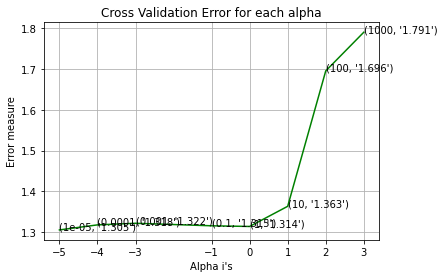

For values of best alpha =  1e-05 The train log loss is: 0.929023251007995
For values of best alpha =  1e-05 The cross validation log loss is: 1.3052469150374255
For values of best alpha =  1e-05 The test log loss is: 1.292046028021362


In [63]:
alpha = [0.00001, 0.0001, 0.001, 0.1, 1, 10, 100,1000]
cv_log_error_array = []
for i in alpha: 
    print("for alpha =", i)
    clf = MultinomialNB(alpha=i)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 


fig, ax = plt.subplots()
ax.plot(np.log10(alpha), cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)): 
    ax.annotate((alpha[i],str(txt)), (np.log10(alpha[i]),cv_log_error_array[i]))
plt.grid()
plt.xticks(np.log10(alpha))
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()
 

best_alpha = np.argmin(cv_log_error_array)
clf = MultinomialNB(alpha=alpha[best_alpha])
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)


predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


<h4>4.1.1.2. Testing the model with best hyper paramters</h4>

Log Loss : 1.3052469150374255
Number of missclassified point : 0.39849624060150374
-------------------- Confusion matrix --------------------


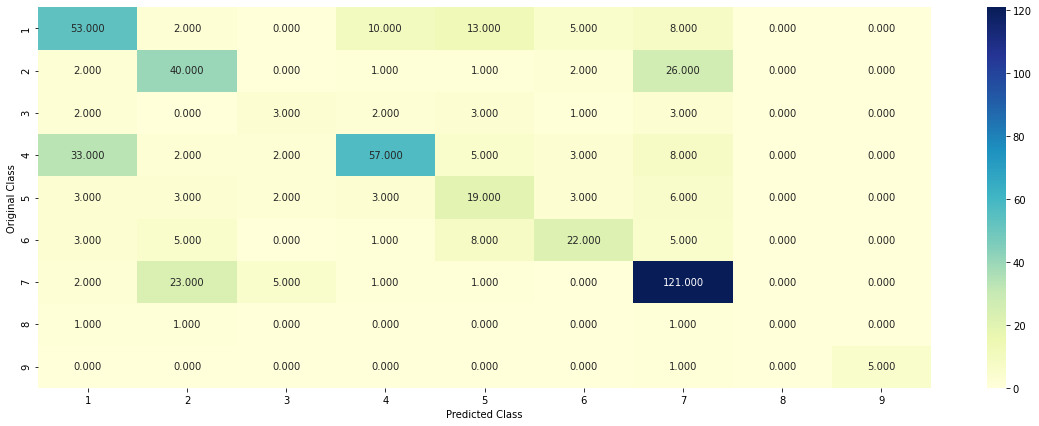

-------------------- Precision matrix (Columm Sum=1) --------------------


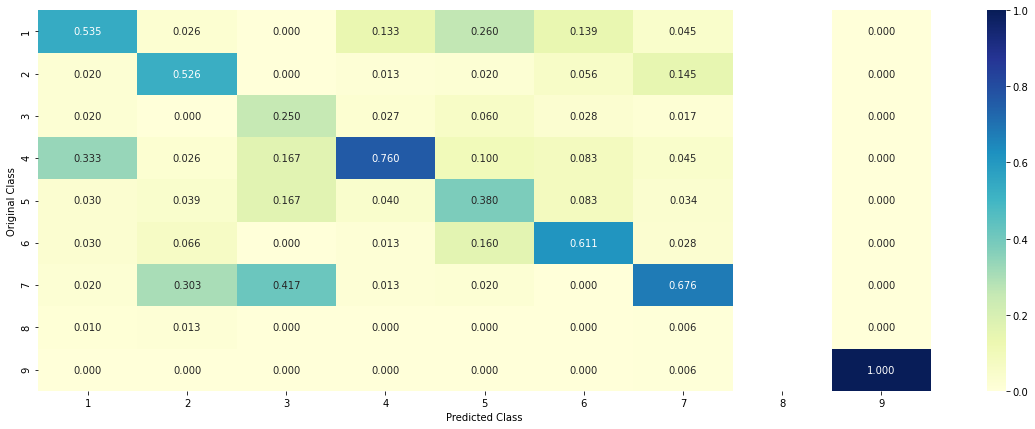

-------------------- Recall matrix (Row sum=1) --------------------


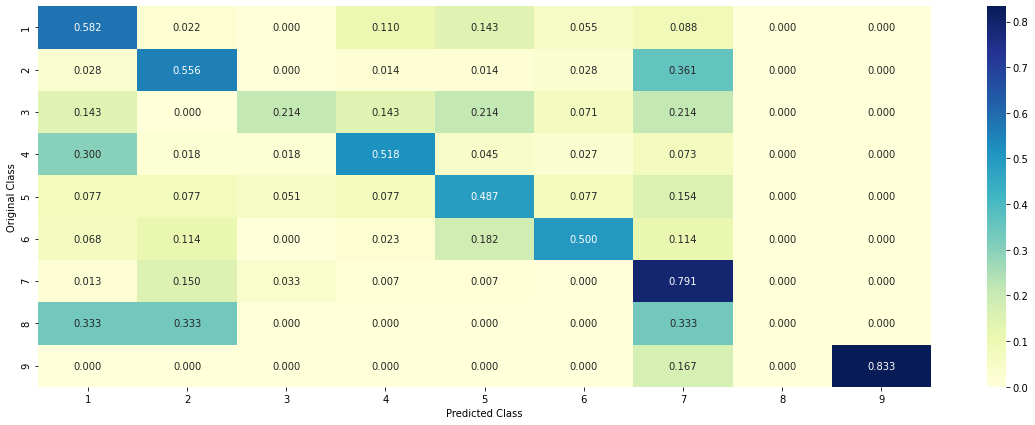

In [64]:
clf = MultinomialNB(alpha = alpha[best_alpha])
clf.fit(train_x_onehotCoding, train_y)  
sig_clf = CalibratedClassifierCV(clf, method = "sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y) 
sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
# to avoid rounding error while multiplying probabilites we use log-probability estimates
print("Log Loss :",log_loss(cv_y, sig_clf_probs))
print("Number of missclassified point :", np.count_nonzero((sig_clf.predict(cv_x_onehotCoding)- cv_y))/cv_y.shape[0])
plot_confusion_matrix(cv_y, sig_clf.predict(cv_x_onehotCoding.toarray()))

In [65]:
test_point_index = 100
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])

Predicted Class : 3
Predicted Class Probabilities: [[0.1042 0.0913 0.4535 0.1204 0.0467 0.0466 0.1263 0.0067 0.0043]]
Actual Class : 7


In [66]:
test_point_index = 90
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])

Predicted Class : 7
Predicted Class Probabilities: [[0.0882 0.0778 0.0109 0.1021 0.0397 0.0394 0.6325 0.0057 0.0038]]
Actual Class : 6


<h3> 4.1.2. K-Nearest Neighbours </h3>

<h4>4.1.2.1 Hyper parameter tuning</h4>

for neighbours = 5
Log Loss : 1.1935932866740728
for neighbours = 11
Log Loss : 1.1906590645470922
for neighbours = 15
Log Loss : 1.191560237731432
for neighbours = 21
Log Loss : 1.1924531035230865
for neighbours = 31
Log Loss : 1.1847897420022864
for neighbours = 41
Log Loss : 1.1812054321211227
for neighbours = 51
Log Loss : 1.181829110737313
for neighbours = 99
Log Loss : 1.1772959822070546


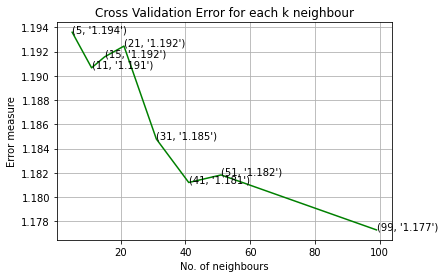

For values of best alpha =  99 The train log loss is: 0.9419906726268443
For values of best alpha =  99 The cross validation log loss is: 1.1772959822070546
For values of best alpha =  99 The test log loss is: 1.1297221862708418


In [67]:
k = [5, 11, 15, 21, 31, 41, 51, 99]
cv_log_error_array = []
for i in k:
    print("for neighbours =", i)
    clf = KNeighborsClassifier(n_neighbors = i)
    clf.fit(train_x_responseCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method = "sigmoid")
    sig_clf.fit(train_x_responseCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_responseCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels = clf.classes_, eps = 1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(k, cv_log_error_array,c = 'g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((k[i],str(txt)), (k[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each k neighbour")
plt.xlabel("No. of neighbours")
plt.ylabel("Error measure")
plt.show()


best_k = np.argmin(cv_log_error_array)
clf = KNeighborsClassifier(n_neighbors = k[best_k])
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method = "sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_responseCoding)
print('For values of best alpha = ', k[best_k], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_responseCoding)
print('For values of best alpha = ', k[best_k], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_responseCoding)
print('For values of best alpha = ', k[best_k], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

<h4>4.1.2.2 Testing the model with best hyper paramters</h4>

Log loss : 1.1772959822070546
Number of mis-classified points : 0.4266917293233083
-------------------- Confusion matrix --------------------


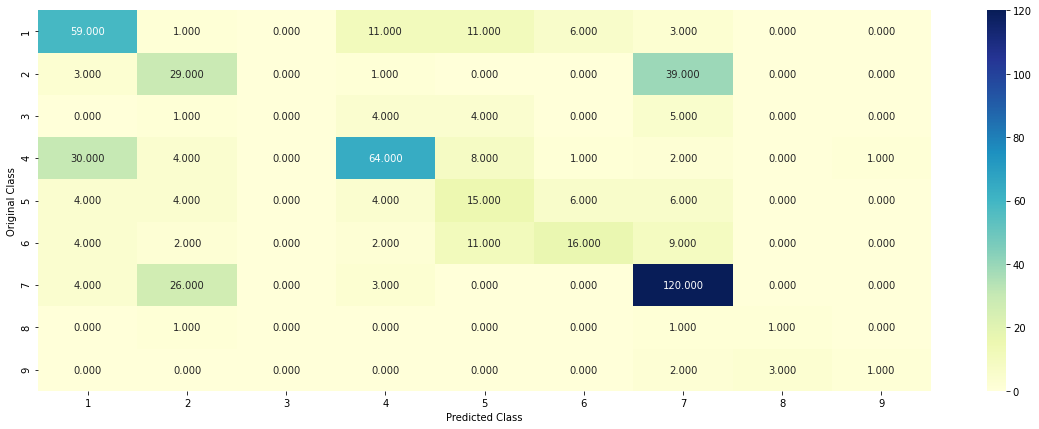

-------------------- Precision matrix (Columm Sum=1) --------------------


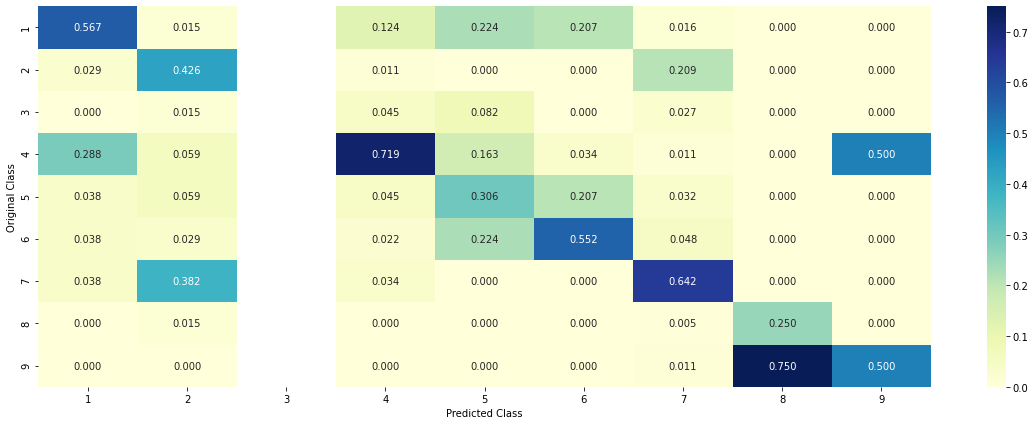

-------------------- Recall matrix (Row sum=1) --------------------


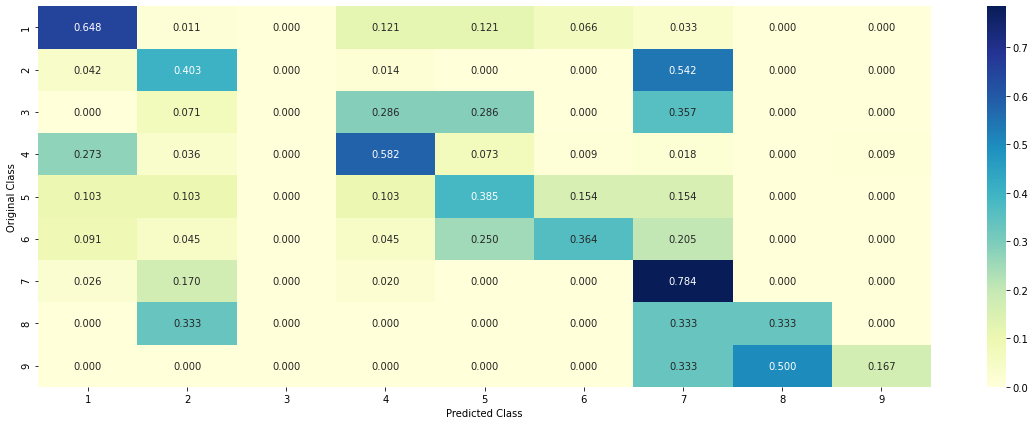

In [68]:
clf = KNeighborsClassifier(n_neighbors = k[best_k])
predict_and_plot_confusion_matrix(train_x_responseCoding, train_y, cv_x_responseCoding, cv_y, clf)

**Working with sample query points**

In [69]:
test_point_index = 1
predicted_cls = sig_clf.predict(test_x_responseCoding[test_point_index].reshape(1,-1))

In [70]:
type(predicted_cls)

numpy.ndarray

In [71]:
predicted_cls.shape

(1,)

In [72]:
print("Predicted Class :", predicted_cls[0])
print("Actual Class :", test_y[test_point_index])
neighbors = clf.kneighbors(test_x_responseCoding[test_point_index].reshape(1, -1), k[best_k])


Predicted Class : 7
Actual Class : 2


In [73]:
neighbors

(array([[0.01036054, 0.0103612 , 0.01036178, 0.01036178, 0.01036181,
         0.01036183, 0.01036193, 0.01036193, 0.01036198, 0.01036208,
         0.01036229, 0.01036229, 0.01036229, 0.01036229, 0.01036229,
         0.01036291, 0.01036291, 0.01036318, 0.01036344, 0.01036349,
         0.01036352, 0.01036356, 0.01036367, 0.01036371, 0.01036384,
         0.01036405, 0.0103642 , 0.01036445, 0.01036474, 0.0103648 ,
         0.01036494, 0.01036499, 0.0103653 , 0.01036557, 0.01036588,
         0.01036602, 0.01036604, 0.01036615, 0.01036624, 0.01036628,
         0.01036638, 0.01036654, 0.01036662, 0.01036665, 0.01036691,
         0.01036691, 0.01036696, 0.01036709, 0.01036709, 0.01036717,
         0.01036717, 0.01036728, 0.01036728, 0.01036728, 0.01036745,
         0.01036745, 0.01036776, 0.01036783, 0.01036797, 0.01036807,
         0.01036871, 0.01036892, 0.01036893, 0.01036911, 0.01036913,
         0.01036936, 0.01036952, 0.01036969, 0.01036969, 0.01036969,
         0.01037058, 0.01037073, 0

In [74]:
print("The ",k[best_k]," nearest neighbours of the test points belongs to classes",train_y[neighbors[1][0]])
print("Fequency of nearest points :",Counter(train_y[neighbors[1][0]]))

The  99  nearest neighbours of the test points belongs to classes [2 7 7 7 7 7 2 2 7 2 4 4 7 7 7 2 2 5 7 7 7 7 7 2 2 7 7 7 2 2 7 2 7 7 7 7 2
 7 2 6 7 2 7 7 2 2 2 7 7 2 7 7 7 7 7 7 7 7 7 2 7 7 7 7 2 7 2 7 7 7 7 8 7 4
 2 5 7 7 7 7 2 7 2 2 7 2 7 7 4 7 7 7 3 2 5 2 2 6 7]
Fequency of nearest points : Counter({7: 59, 2: 29, 4: 4, 5: 3, 6: 2, 8: 1, 3: 1})


In [75]:
test_point_index = 35

predicted_cls = sig_clf.predict(test_x_responseCoding[test_point_index].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Actual Class :", test_y[test_point_index])
neighbors = clf.kneighbors(test_x_responseCoding[test_point_index].reshape(1, -1), k[best_k])
print("the k value for knn is",k[best_k],"and the nearest neighbours of the test points belongs to classes",train_y[neighbors[1][0]])
print("Fequency of nearest points :",Counter(train_y[neighbors[1][0]]))

Predicted Class : 5
Actual Class : 1
the k value for knn is 99 and the nearest neighbours of the test points belongs to classes [1 1 5 5 4 4 5 5 5 5 1 4 5 4 1 4 4 1 1 1 1 1 5 5 5 5 5 5 6 6 4 1 1 4 5 5 1
 1 1 1 1 1 1 1 1 1 1 5 5 5 5 5 5 5 5 5 5 6 4 4 6 4 4 4 1 5 6 4 4 5 5 4 1 1
 1 1 1 4 5 1 1 4 1 5 5 1 1 5 4 5 4 4 5 4 4 5 4 4 4]
Fequency of nearest points : Counter({5: 35, 1: 33, 4: 26, 6: 5})


<h3> 4.1.3 Logistic Regression </h3>

<h4> 4.1.3.1 With class balancing </h4> 

<h4> 4.1.3.1.1 Hyperparameter Tuning </h4>

for alpha = 1e-06
Log Loss : 1.8308896108218553
for alpha = 1e-05
Log Loss : 1.8308896108218553
for alpha = 0.0001
Log Loss : 1.8308896108218553
for alpha = 0.001
Log Loss : 1.303544287268461
for alpha = 0.01
Log Loss : 1.2644108648733914
for alpha = 0.1
Log Loss : 1.271959597195625
for alpha = 1
Log Loss : 1.1609810511721415
for alpha = 10
Log Loss : 1.1770009285903806
for alpha = 100
Log Loss : 1.3370019739543957


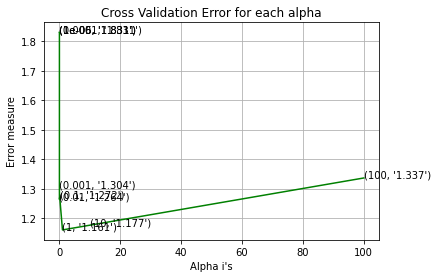

For values of best alpha =  1 The train log loss is: 0.8219919410518556
For values of best alpha =  1 The cross validation log loss is: 1.1609810511721415
For values of best alpha =  1 The test log loss is: 1.167875891884487


In [76]:
alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

<h4> 4.1.3.1.2 Testing with best hyperparameters </h4>

Log loss : 1.1609810511721415
Number of mis-classified points : 0.35526315789473684
-------------------- Confusion matrix --------------------


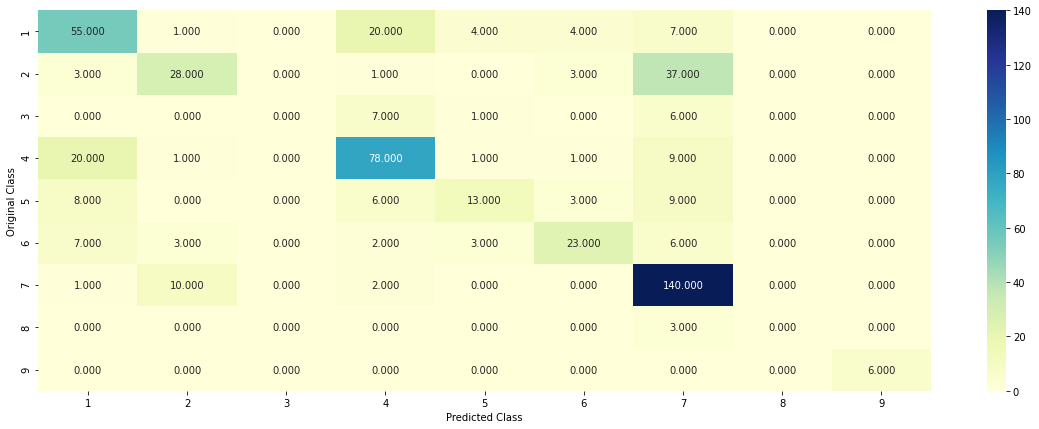

-------------------- Precision matrix (Columm Sum=1) --------------------


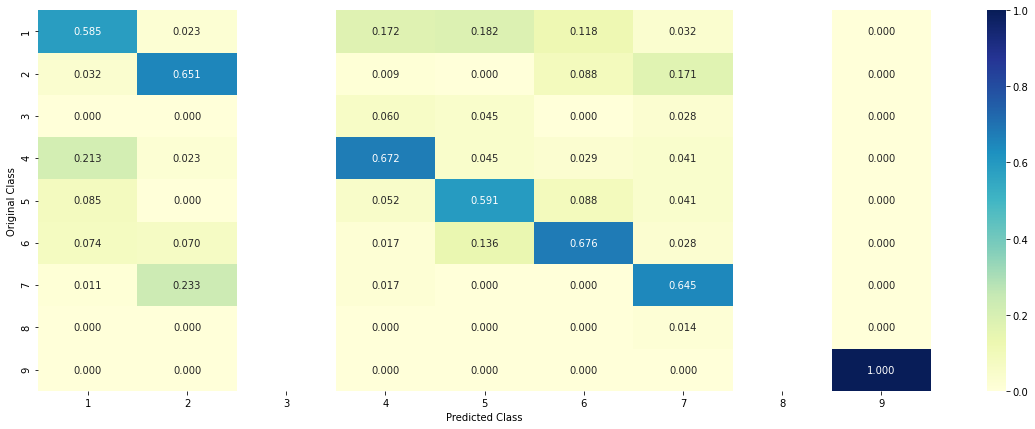

-------------------- Recall matrix (Row sum=1) --------------------


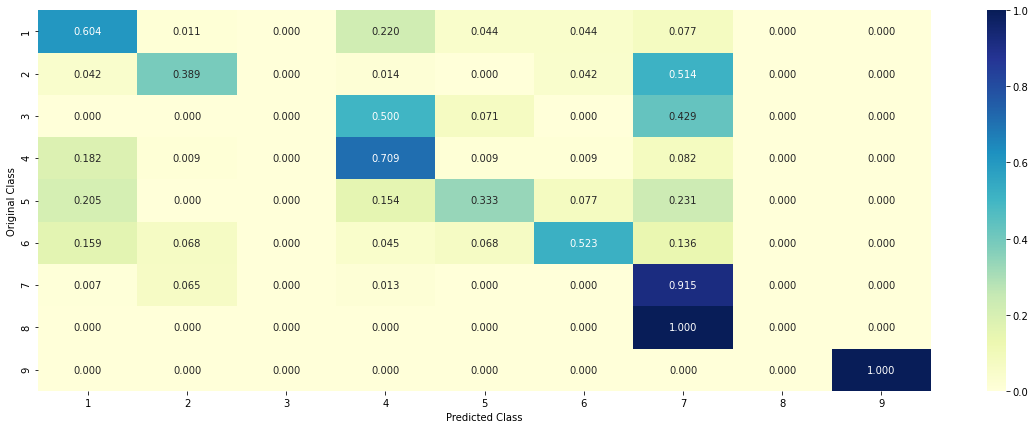

In [77]:
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y, cv_x_onehotCoding, cv_y, clf)

**Testing with sample query points**

In [78]:
# from tabulate import tabulate
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding,train_y)
test_point_index = 1
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-1*abs(clf.coef_))[predicted_cls-1][:,:no_feature]
print("-"*50)

Predicted Class : 7
Predicted Class Probabilities: [[0.1269 0.2231 0.019  0.0936 0.1482 0.0876 0.2874 0.0065 0.0076]]
Actual Class : 2
--------------------------------------------------


<h4> 4.1.3.2 Without class balancing </h4> 

for alpha = 1e-06
Log Loss : 1.8308896108218553
for alpha = 1e-05
Log Loss : 1.8308896108218553
for alpha = 0.0001
Log Loss : 1.8308896108218553
for alpha = 0.001
Log Loss : 1.2882305987300369
for alpha = 0.01
Log Loss : 1.2754735955499361
for alpha = 0.1
Log Loss : 1.2600684850197044
for alpha = 1
Log Loss : 1.181958896186598


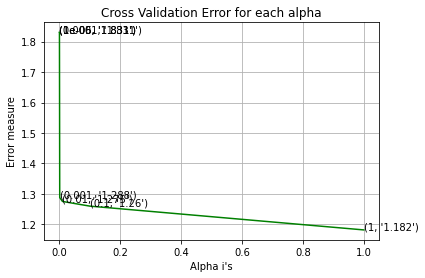

For values of best alpha =  1 The train log loss is: 0.8284850081392028
For values of best alpha =  1 The cross validation log loss is: 1.181958896186598
For values of best alpha =  1 The test log loss is: 1.1705712538493591


In [79]:
alpha = [10 ** x for x in range(-6, 1)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

<h4> 4.1.3.2 Testing with best hyperparameters </h4> 

Log loss : 1.181958896186598
Number of mis-classified points : 0.3533834586466165
-------------------- Confusion matrix --------------------


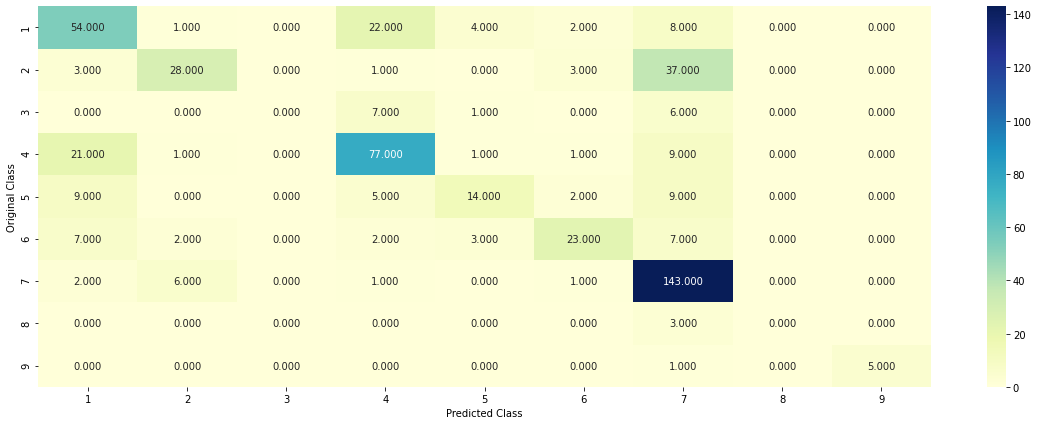

-------------------- Precision matrix (Columm Sum=1) --------------------


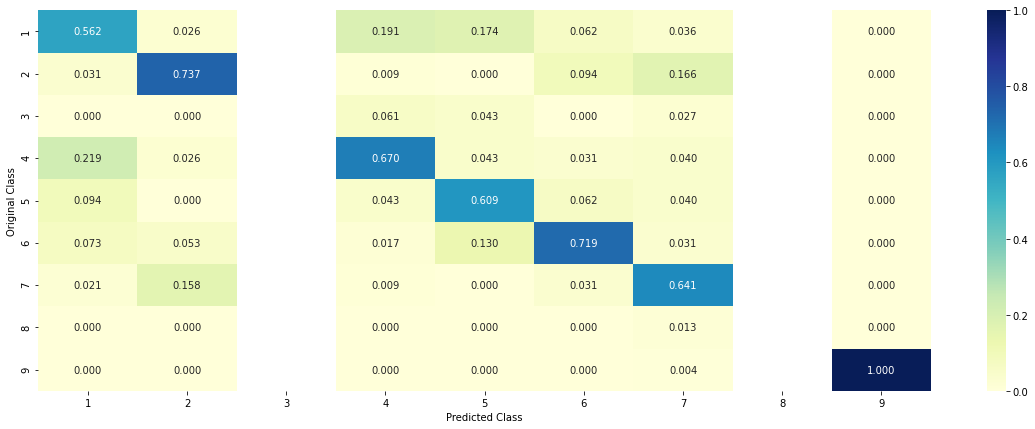

-------------------- Recall matrix (Row sum=1) --------------------


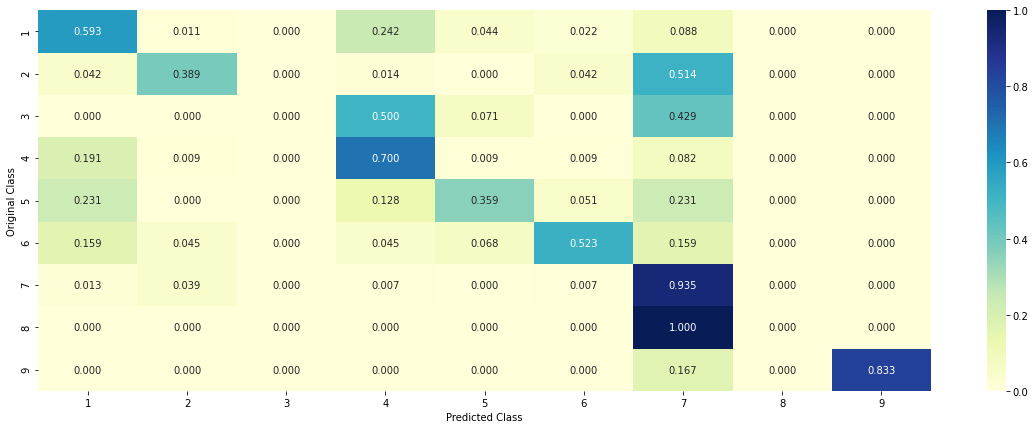

In [80]:
clf = SGDClassifier(alpha = alpha[best_alpha], penalty = 'l2', loss = 'log', random_state = 42)
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y, cv_x_onehotCoding, cv_y, clf)

**Testing with sample points**

In [81]:
test_point_index = 1
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])

Predicted Class : 7
Predicted Class Probabilities: [[0.128  0.2353 0.0226 0.0863 0.1648 0.0871 0.2605 0.0069 0.0085]]
Actual Class : 2


In [82]:
test_point_index = 100
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])

Predicted Class : 7
Predicted Class Probabilities: [[0.1192 0.122  0.316  0.03   0.0273 0.0079 0.37   0.0066 0.0011]]
Actual Class : 7


<h3> 4.1.4 Support Vector Machine </h3>

<h4> 4.1.4.1 Hyperparameter Tuning </h4>

for C = 1e-05
Log Loss : 1.8308896108218553
for C = 0.0001
Log Loss : 1.8308896108218553
for C = 0.001
Log Loss : 1.300568287937938
for C = 0.01
Log Loss : 1.276288454770416
for C = 0.1
Log Loss : 1.2553949186186697
for C = 1
Log Loss : 1.2267599582569717
for C = 10
Log Loss : 1.2052988868513073
for C = 100
Log Loss : 1.3301797197670902


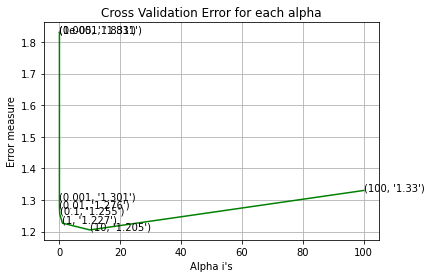

For values of best alpha =  10 The train log loss is: 0.8834073499838889
For values of best alpha =  10 The cross validation log loss is: 1.2052988868513073
For values of best alpha =  10 The test log loss is: 1.2087099001521084


In [83]:
alpha = [10 ** x for x in range(-5, 3)]
cv_log_error_array = []
for i in alpha:
    print("for C =", i)
    clf = SGDClassifier( class_weight = 'balanced', alpha = i, penalty = 'l2', loss = 'hinge', random_state = 42)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method = "sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps = 1e-15))
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c = 'g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

<h4> 4.1.4.2 Testing with best hyperparameters </h4> 

Log loss : 1.2052988868513073
Number of mis-classified points : 0.3609022556390977
-------------------- Confusion matrix --------------------


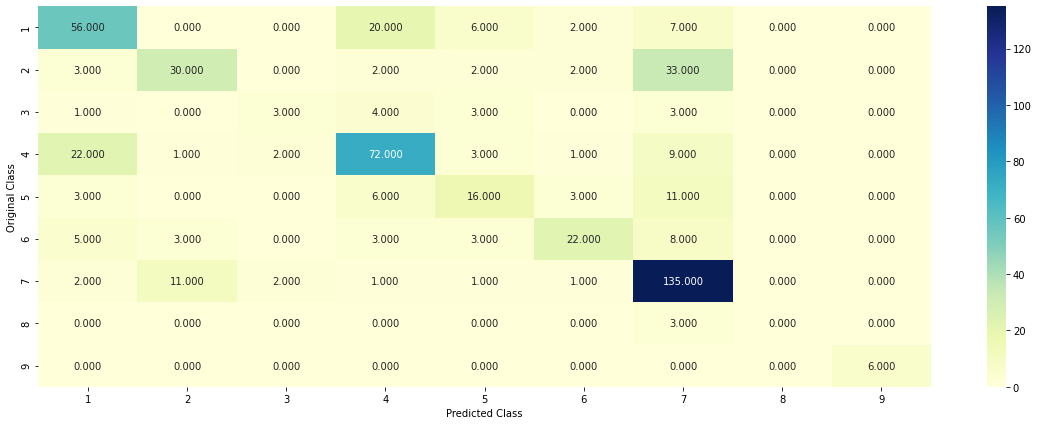

-------------------- Precision matrix (Columm Sum=1) --------------------


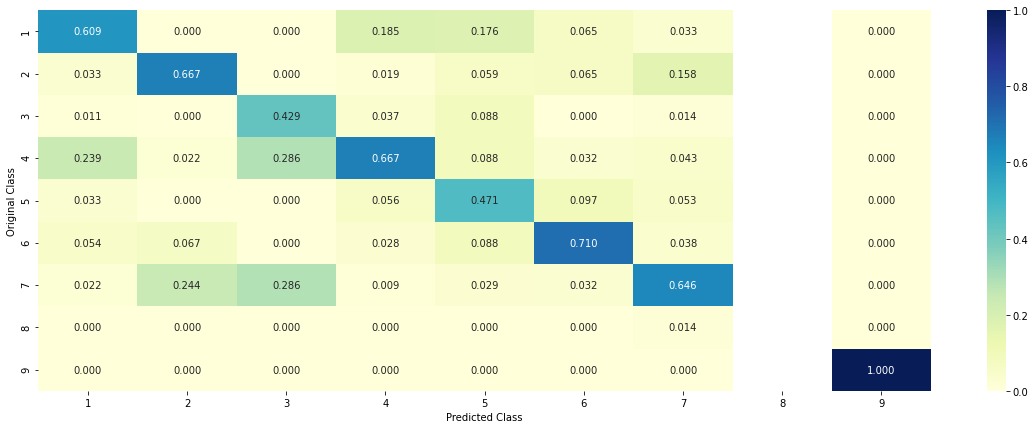

-------------------- Recall matrix (Row sum=1) --------------------


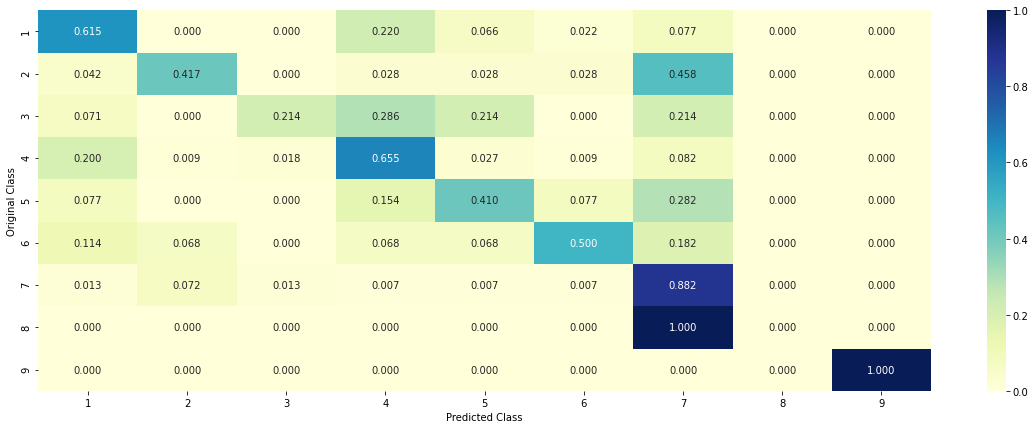

In [84]:
clf = SGDClassifier(alpha = alpha[best_alpha], penalty = 'l2', loss = 'hinge', random_state = 42,class_weight = 'balanced')
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y,cv_x_onehotCoding,cv_y, clf)

**Testing with random sample points**

In [85]:
test_point_index = 1
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])

Predicted Class : 7
Predicted Class Probabilities: [[0.1461 0.2429 0.0171 0.125  0.1278 0.0719 0.2563 0.0068 0.0061]]
Actual Class : 2


In [86]:
test_point_index = 100
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])

Predicted Class : 3
Predicted Class Probabilities: [[0.1231 0.102  0.4001 0.0353 0.0245 0.005  0.3025 0.0058 0.0016]]
Actual Class : 7


<h3> 4.1.5 Random Forest Classifier </h3>

<h4> 4.1.5.1 Hyperparameter Tuning (Using one hot encoded data) </h4>

In [87]:
n_estimators = [100,200,500,1000,2000]
max_depth = [5, 10]
cv_log_error_array = []
for i in n_estimators:
    for j in max_depth:
        print("for n_estimators =", i,"and max depth = ", j)
        clf = RandomForestClassifier(n_estimators = i, criterion = 'gini', max_depth = j, random_state = 42, n_jobs = -1)
        clf.fit(train_x_onehotCoding, train_y)
        sig_clf = CalibratedClassifierCV(clf, method = "sigmoid")
        sig_clf.fit(train_x_onehotCoding, train_y)
        sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
        cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
        print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

for n_estimators = 100 and max depth =  5
Log Loss : 1.1947819440234444
for n_estimators = 100 and max depth =  10
Log Loss : 1.1078400246637243
for n_estimators = 200 and max depth =  5
Log Loss : 1.1834250821451344
for n_estimators = 200 and max depth =  10
Log Loss : 1.10335527361676
for n_estimators = 500 and max depth =  5
Log Loss : 1.1818359576659605
for n_estimators = 500 and max depth =  10
Log Loss : 1.10202554353294
for n_estimators = 1000 and max depth =  5
Log Loss : 1.1793747335211449
for n_estimators = 1000 and max depth =  10
Log Loss : 1.1029734470396255
for n_estimators = 2000 and max depth =  5
Log Loss : 1.176437300618852
for n_estimators = 2000 and max depth =  10
Log Loss : 1.1022693360988527


In [88]:
best_alpha = np.argmin(cv_log_error_array)
print(best_alpha)

5


In [89]:
cv_log_error_array

[1.1947819440234444,
 1.1078400246637243,
 1.1834250821451344,
 1.10335527361676,
 1.1818359576659605,
 1.10202554353294,
 1.1793747335211449,
 1.1029734470396255,
 1.176437300618852,
 1.1022693360988527]

<h4> 4.1.5.2 Testing with best hyperparameters </h4>

In [90]:
clf = RandomForestClassifier(n_estimators = n_estimators[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha % 2)], random_state=42, n_jobs=-1)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

CalibratedClassifierCV(base_estimator=RandomForestClassifier(max_depth=10,
                                                             n_estimators=500,
                                                             n_jobs=-1,
                                                             random_state=42))

In [91]:
predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best estimator = ', n_estimators[int(best_alpha/2)], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best estimator = ', n_estimators[int(best_alpha/2)], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best estimator = ', n_estimators[int(best_alpha/2)], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

For values of best estimator =  500 The train log loss is: 0.6849163324398566
For values of best estimator =  500 The cross validation log loss is: 1.10202554353294
For values of best estimator =  500 The test log loss is: 1.0700334941149179


Log loss : 1.10202554353294
Number of mis-classified points : 0.37593984962406013
-------------------- Confusion matrix --------------------


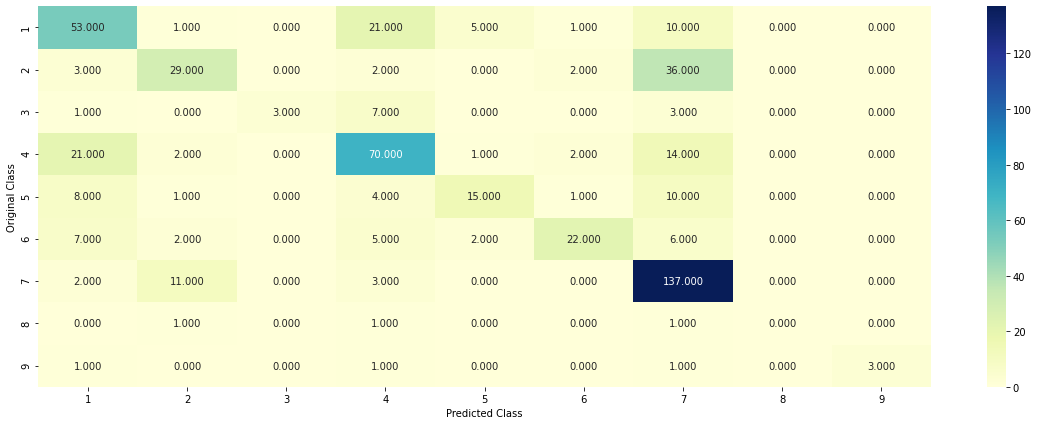

-------------------- Precision matrix (Columm Sum=1) --------------------


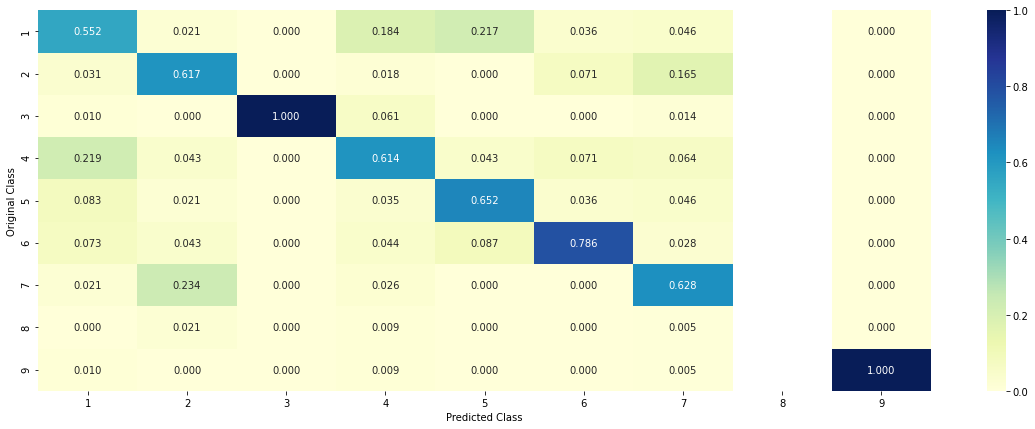

-------------------- Recall matrix (Row sum=1) --------------------


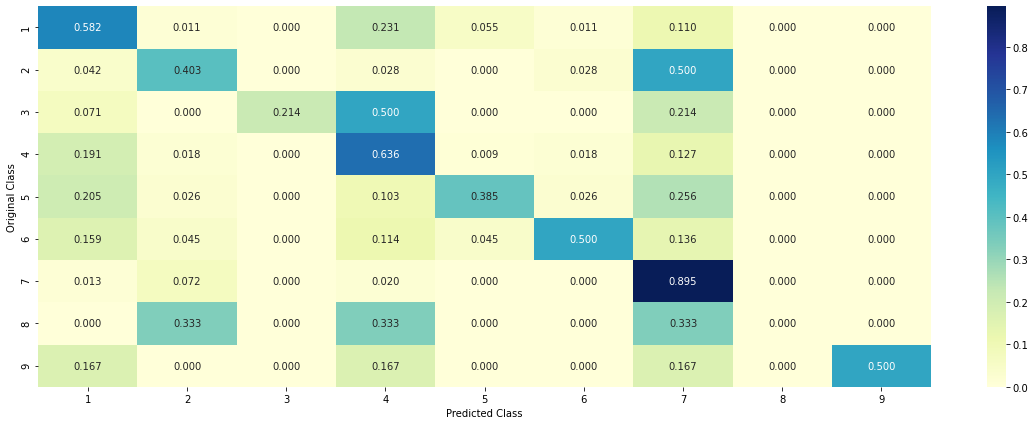

In [92]:
clf = RandomForestClassifier(n_estimators = n_estimators[int(best_alpha/2)], criterion = 'gini', max_depth = max_depth[int(best_alpha%2)], random_state = 42, n_jobs = -1)
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y,cv_x_onehotCoding,cv_y, clf)

**Testing with random sample points**

In [93]:
test_point_index = 1
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])

Predicted Class : 2
Predicted Class Probabilities: [[0.0641 0.6805 0.0136 0.0677 0.0381 0.0338 0.0926 0.0045 0.0052]]
Actual Class : 2


In [94]:
test_point_index = 100
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])

Predicted Class : 3
Predicted Class Probabilities: [[0.0308 0.0542 0.4581 0.0321 0.0378 0.0293 0.3487 0.0044 0.0047]]
Actual Class : 7


<h4> 4.1.5.1 Hyperparameter Tuning (Using response coding) </h4>

In [95]:
n_estimators = [10,50,100,200,500,1000]
max_depth = [2,3,5,10]
cv_log_error_array = []
for i in n_estimators:
    for j in max_depth:
        print("for n_estimators =", i,"and max depth = ", j)
        clf = RandomForestClassifier(n_estimators = i, criterion='gini', max_depth=j, random_state=42, n_jobs=-1)
        clf.fit(train_x_responseCoding, train_y)
        sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
        sig_clf.fit(train_x_responseCoding, train_y)
        sig_clf_probs = sig_clf.predict_proba(cv_x_responseCoding)
        cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
        print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 


best_alpha = np.argmin(cv_log_error_array)
clf = RandomForestClassifier(n_estimators = n_estimators[int(best_alpha/4)], criterion='gini', max_depth=max_depth[int(best_alpha%4)], random_state=42, n_jobs=-1)
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_responseCoding)
print('For values of best n_estimators = ', n_estimators[int(best_alpha/4)], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_responseCoding)
print('For values of best n_estimators = ', n_estimators[int(best_alpha/4)], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_responseCoding)
print('For values of best n_estimators = ', n_estimators[int(best_alpha/4)], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

for n_estimators = 10 and max depth =  2
Log Loss : 2.0617639053638226
for n_estimators = 10 and max depth =  3
Log Loss : 1.7019550224836504
for n_estimators = 10 and max depth =  5
Log Loss : 1.4504629092847068
for n_estimators = 10 and max depth =  10
Log Loss : 1.7914136901554016
for n_estimators = 50 and max depth =  2
Log Loss : 1.712178540760712
for n_estimators = 50 and max depth =  3
Log Loss : 1.4962910277439423
for n_estimators = 50 and max depth =  5
Log Loss : 1.377659571582114
for n_estimators = 50 and max depth =  10
Log Loss : 1.7045438897183738
for n_estimators = 100 and max depth =  2
Log Loss : 1.6756459399308643
for n_estimators = 100 and max depth =  3
Log Loss : 1.404645488065562
for n_estimators = 100 and max depth =  5
Log Loss : 1.3170220212994894
for n_estimators = 100 and max depth =  10
Log Loss : 1.6981664742745
for n_estimators = 200 and max depth =  2
Log Loss : 1.6176441527809504
for n_estimators = 200 and max depth =  3
Log Loss : 1.4068835248568148
for

<h4> 4.1.5.2 Testing with best hyperparameters </h4>

Log loss : 1.3170220212994896
Number of mis-classified points : 0.4492481203007519
-------------------- Confusion matrix --------------------


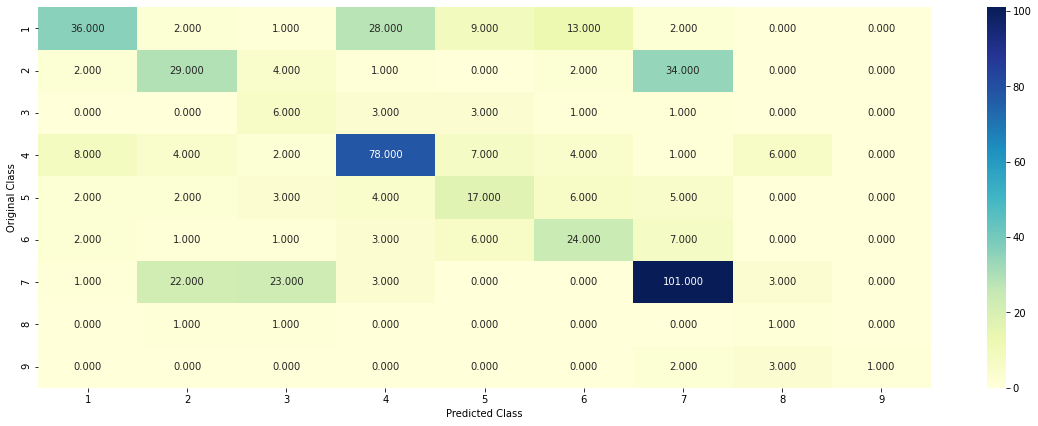

-------------------- Precision matrix (Columm Sum=1) --------------------


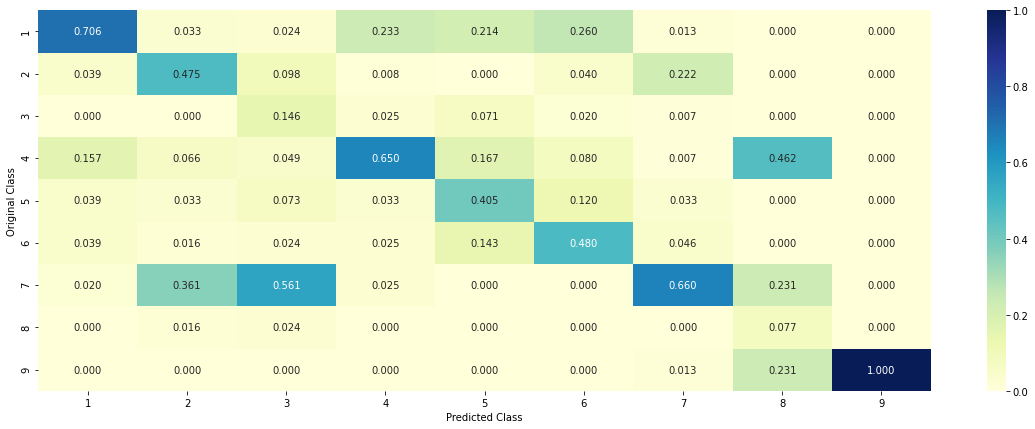

-------------------- Recall matrix (Row sum=1) --------------------


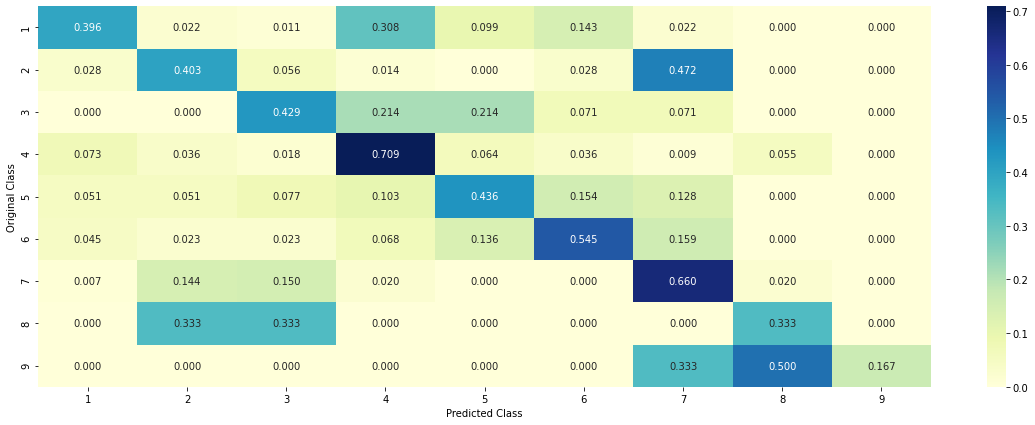

In [96]:
clf = RandomForestClassifier(max_depth = max_depth[int(best_alpha % 4)], n_estimators = n_estimators[int(best_alpha/4)], criterion = 'gini', max_features ='auto',random_state = 42)
predict_and_plot_confusion_matrix(train_x_responseCoding, train_y,cv_x_responseCoding,cv_y, clf)

**Testing with random sample points**

In [97]:
test_point_index = 1
no_feature = 27
predicted_cls = sig_clf.predict(test_x_responseCoding[test_point_index].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_responseCoding[test_point_index].reshape(1,-1)),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.feature_importances_)
print("-"*50)
for i in indices:
    if i<9:
        print("Gene is important feature")
    elif i<18:
        print("Variation is important feature")
    else:
        print("Text is important feature")

Predicted Class : 7
Predicted Class Probabilities: [[0.0203 0.2413 0.12   0.0416 0.0502 0.194  0.2717 0.0381 0.0228]]
Actual Class : 2
--------------------------------------------------
Variation is important feature
Variation is important feature
Variation is important feature
Variation is important feature
Gene is important feature
Variation is important feature
Variation is important feature
Gene is important feature
Gene is important feature
Gene is important feature
Variation is important feature
Text is important feature
Text is important feature
Text is important feature
Gene is important feature
Gene is important feature
Text is important feature
Text is important feature
Text is important feature
Variation is important feature
Text is important feature
Variation is important feature
Gene is important feature
Text is important feature
Gene is important feature
Text is important feature
Gene is important feature


In [98]:
test_point_index = 100
no_feature = 27
predicted_cls = sig_clf.predict(test_x_responseCoding[test_point_index].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_responseCoding[test_point_index].reshape(1,-1)),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.feature_importances_)
print("-"*50)
for i in indices:
    if i<9:
        print("Gene is important feature")
    elif i<18:
        print("Variation is important feature")
    else:
        print("Text is important feature")

Predicted Class : 3
Predicted Class Probabilities: [[0.0082 0.0576 0.7311 0.0115 0.0164 0.0349 0.1135 0.0175 0.0093]]
Actual Class : 7
--------------------------------------------------
Variation is important feature
Variation is important feature
Variation is important feature
Variation is important feature
Gene is important feature
Variation is important feature
Variation is important feature
Gene is important feature
Gene is important feature
Gene is important feature
Variation is important feature
Text is important feature
Text is important feature
Text is important feature
Gene is important feature
Gene is important feature
Text is important feature
Text is important feature
Text is important feature
Variation is important feature
Text is important feature
Variation is important feature
Gene is important feature
Text is important feature
Gene is important feature
Text is important feature
Gene is important feature


<h1> 5. Stack The Models </h1>

<h3> 5.1 Stacking Classifier </h3>

<h4> 5.1.1 Hyperparameter Tuning </h4> 

In [99]:
clf1 = SGDClassifier(alpha = 10, penalty='l2', loss='log', class_weight='balanced', random_state=0)
clf1.fit(train_x_onehotCoding, train_y)
sig_clf1 = CalibratedClassifierCV(clf1, method="sigmoid")

clf2 = SGDClassifier(alpha=10, penalty='l2', loss='hinge', class_weight='balanced', random_state=0)
clf2.fit(train_x_onehotCoding, train_y)
sig_clf2 = CalibratedClassifierCV(clf2, method="sigmoid")


clf3 = MultinomialNB(alpha = 0.00001)
clf3.fit(train_x_onehotCoding, train_y)
sig_clf3 = CalibratedClassifierCV(clf3, method="sigmoid")

sig_clf1.fit(train_x_onehotCoding, train_y)
print("Logistic Regression :  Log Loss: %0.2f" % (log_loss(cv_y, sig_clf1.predict_proba(cv_x_onehotCoding))))

sig_clf2.fit(train_x_onehotCoding, train_y)
print("Support vector machines : Log Loss: %0.2f" % (log_loss(cv_y, sig_clf2.predict_proba(cv_x_onehotCoding))))

sig_clf3.fit(train_x_onehotCoding, train_y)
print("Naive Bayes : Log Loss: %0.2f" % (log_loss(cv_y, sig_clf3.predict_proba(cv_x_onehotCoding))))

print("-"*50)

alpha = [0.0001,0.001,0.01,0.1,1,10] 

cv_log_error = []
for i in alpha:
    lr = LogisticRegression(C = i,solver='liblinear')
    sclf = StackingClassifier(classifiers=[sig_clf1, sig_clf2, sig_clf3], meta_classifier = lr, use_probas = True)
    sclf.fit(train_x_onehotCoding, train_y)
    print("Stacking Classifer : for the value of alpha: %f Log Loss: %0.3f" % (i, log_loss(cv_y, sclf.predict_proba(cv_x_onehotCoding))))
    log_error = log_loss(cv_y, sclf.predict_proba(cv_x_onehotCoding))
    cv_log_error.append(log_error)

Logistic Regression :  Log Loss: 1.18
Support vector machines : Log Loss: 1.21
Naive Bayes : Log Loss: 1.31
--------------------------------------------------
Stacking Classifer : for the value of alpha: 0.000100 Log Loss: 2.178
Stacking Classifer : for the value of alpha: 0.001000 Log Loss: 2.042
Stacking Classifer : for the value of alpha: 0.010000 Log Loss: 1.567
Stacking Classifer : for the value of alpha: 0.100000 Log Loss: 1.170
Stacking Classifer : for the value of alpha: 1.000000 Log Loss: 1.133
Stacking Classifer : for the value of alpha: 10.000000 Log Loss: 1.183


<h4> 5.1.2 Testing the model with best hyperparameters </h4>

Log loss (train) on the stacking classifier : 0.5776668265483021
Log loss (CV) on the stacking classifier : 1.1964805314762412
Log loss (test) on the stacking classifier : 1.1631960450663184
Number of missclassified point : 0.37593984962406013
-------------------- Confusion matrix --------------------


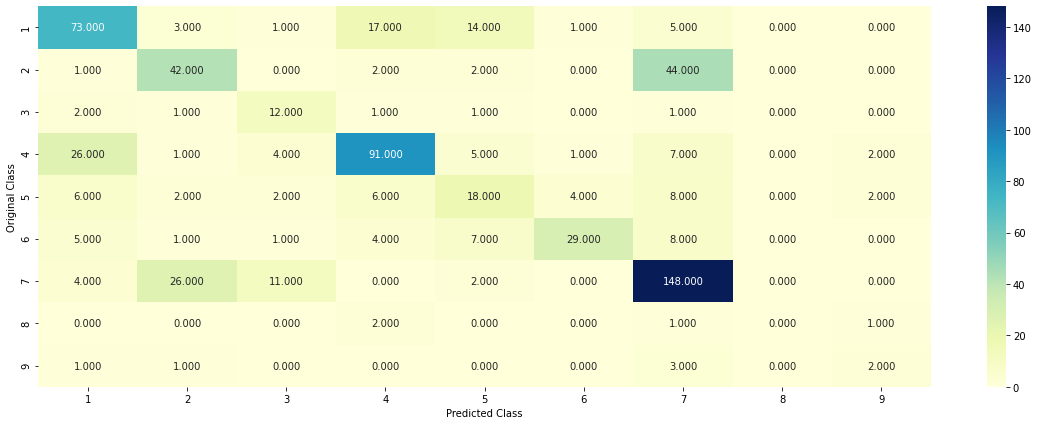

-------------------- Precision matrix (Columm Sum=1) --------------------


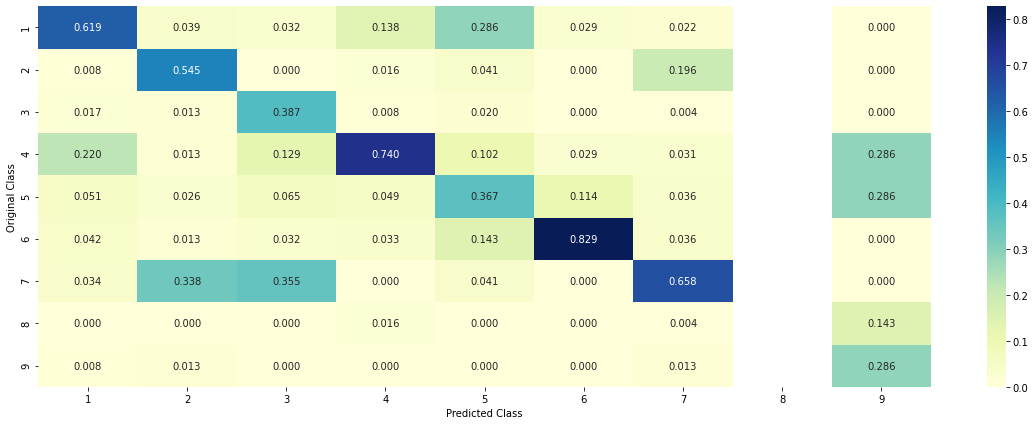

-------------------- Recall matrix (Row sum=1) --------------------


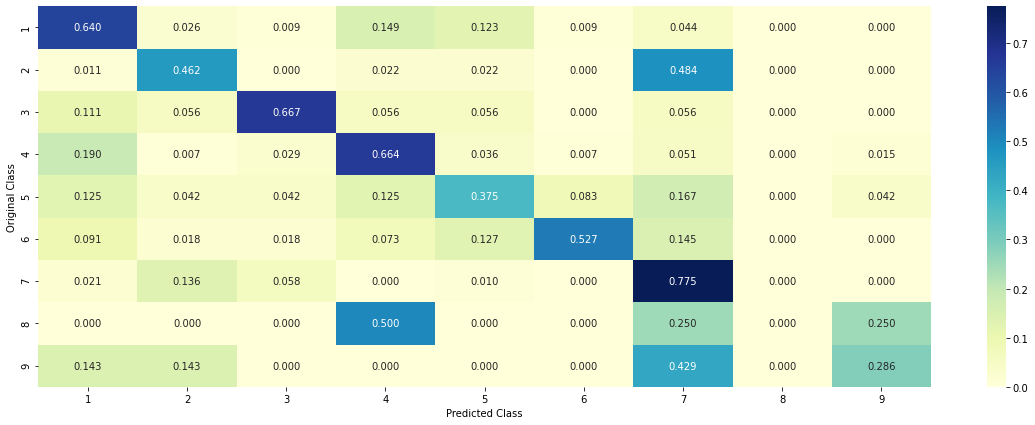

In [100]:
best_alpha = np.argmin(cv_log_error)
lr = LogisticRegression(C = cv_log_error[best_alpha])
sclf = StackingClassifier(classifiers=[sig_clf1, sig_clf2, sig_clf3], meta_classifier=lr, use_probas=True)
sclf.fit(train_x_onehotCoding, train_y)

log_error = log_loss(train_y, sclf.predict_proba(train_x_onehotCoding))
print("Log loss (train) on the stacking classifier :",log_error)

log_error = log_loss(cv_y, sclf.predict_proba(cv_x_onehotCoding))
print("Log loss (CV) on the stacking classifier :",log_error)

log_error = log_loss(test_y, sclf.predict_proba(test_x_onehotCoding))
print("Log loss (test) on the stacking classifier :",log_error)

print("Number of missclassified point :", np.count_nonzero((sclf.predict(test_x_onehotCoding)- test_y))/test_y.shape[0])
plot_confusion_matrix(test_y=test_y, predict_y=sclf.predict(test_x_onehotCoding))

<h3> 5.2 Maximum Voting Classifier </h3> 

Log loss (train) on the VotingClassifier : 0.8649627348838181
Log loss (CV) on the VotingClassifier : 1.1784867461710473
Log loss (test) on the VotingClassifier : 1.16360176284489
Number of missclassified point : 0.37293233082706767
-------------------- Confusion matrix --------------------


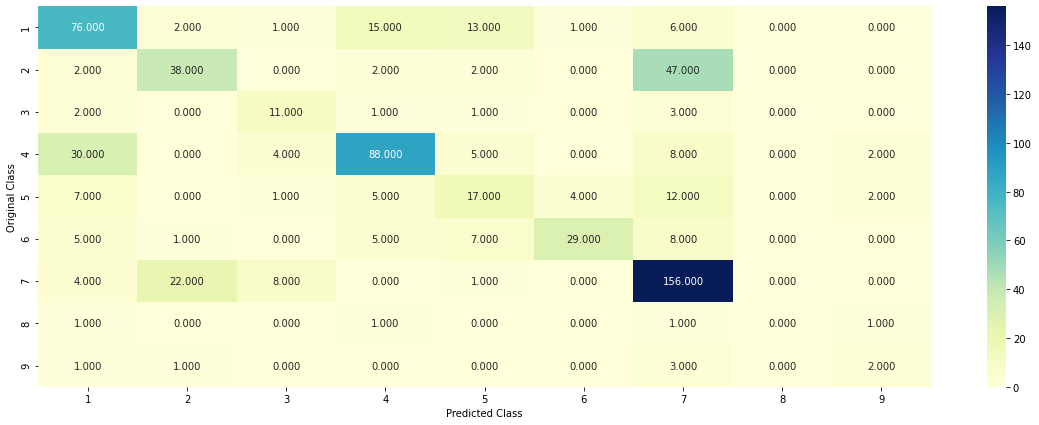

-------------------- Precision matrix (Columm Sum=1) --------------------


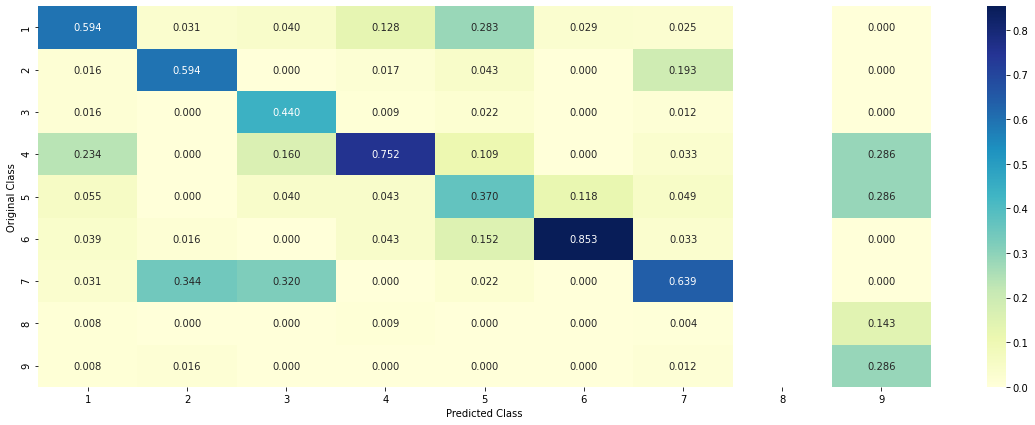

-------------------- Recall matrix (Row sum=1) --------------------


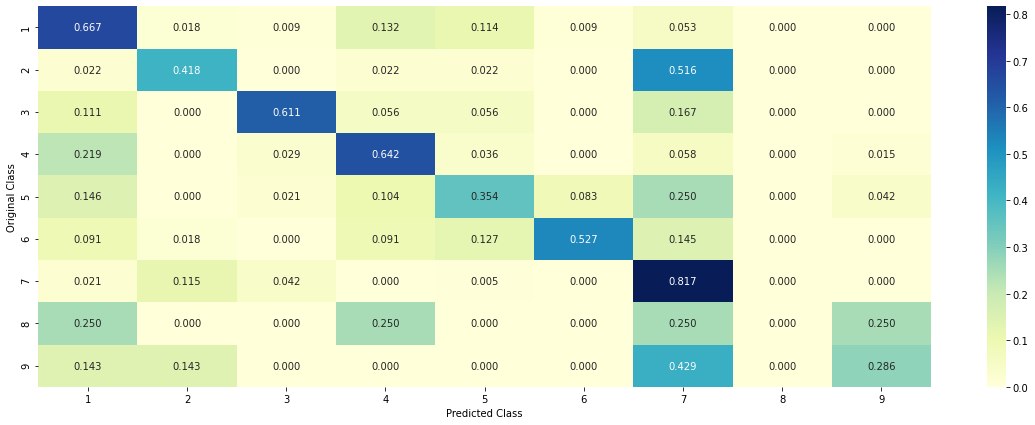

In [101]:
from sklearn.ensemble import VotingClassifier
vclf = VotingClassifier(estimators=[('lr', sig_clf1), ('svc', sig_clf2), ('nb', sig_clf3)], voting='soft')
vclf.fit(train_x_onehotCoding, train_y)
print("Log loss (train) on the VotingClassifier :", log_loss(train_y, vclf.predict_proba(train_x_onehotCoding)))
print("Log loss (CV) on the VotingClassifier :", log_loss(cv_y, vclf.predict_proba(cv_x_onehotCoding)))
print("Log loss (test) on the VotingClassifier :", log_loss(test_y, vclf.predict_proba(test_x_onehotCoding)))
print("Number of missclassified point :", np.count_nonzero((vclf.predict(test_x_onehotCoding)- test_y))/test_y.shape[0])
plot_confusion_matrix(test_y=test_y, predict_y=vclf.predict(test_x_onehotCoding))